# 1. Package and dataset setup

In [1]:
%%capture
!wget https://huggingface.co/timm/eva02_enormous_patch14_plus_clip_224.laion2b_s9b_b144k/resolve/main/open_clip_pytorch_model.bin

In [1]:
%%capture
!git clone https://github.com/Ugo-Insalaco/Uni3D.git
!pip install -r Uni3D/requirements.txt

In [2]:
%%capture
!wget https://huggingface.co/BAAI/Uni3D/resolve/main/modelzoo/uni3d-g-no-lvis/model.pt uni3dg.pt
!mv model.pt Uni3D/models/uni3dg.pt

In [3]:
%%capture
!mv Uni3D/pointnet2_ops_lib/ pointnet2_ops_lib
!pip install pointnet2_ops_lib/. --verbose

In [5]:
%cd Uni3D

/kaggle/working/Uni3D


# 2. CLIP Embeddings computation

In [2]:
%%capture
!pip install open-clip-torch

In [6]:
from utils.tokenizer import SimpleTokenizer
import open_clip
import numpy as np
from PIL import Image

ModuleNotFoundError: No module named 'utils'

In [3]:
import open_clip
clip_model_name="EVA02-E-14-plus" 
pretrained="open_clip_pytorch_model.bin"
clip_model, _, preprocess = open_clip.create_model_and_transforms(model_name=clip_model_name, pretrained=pretrained) 

## 2.1 Text embeddings

In [5]:
# tokenizer = SimpleTokenizer()
tokenizer = open_clip.get_tokenizer(clip_model_name)

In [6]:
text = "A butterfly with a blue wing and a yellow wing."
texts = tokenizer([text]).to('cpu', non_blocking=True)
if len(texts.shape) < 2:
    texts = texts[None, ...]
print(texts.shape)
print(texts)

torch.Size([1, 77])
tensor([[49406,   320,  9738,   593,   320,  1746,  1340,   537,   320,  4481,
          1340,   269, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])


In [7]:
class_embeddings = clip_model.encode_text(texts)
class_embeddings = class_embeddings / class_embeddings.norm(dim=-1, keepdim=True)
class_embeddings = class_embeddings.mean(dim=0)
class_embeddings = class_embeddings / class_embeddings.norm(dim=-1, keepdim=True)

In [8]:
import numpy as np
np.save('embeddings.npy', class_embeddings.detach().numpy())
print(class_embeddings.shape)
print(class_embeddings)

torch.Size([1024])
tensor([-0.0218,  0.0005, -0.0107,  ..., -0.0203, -0.0232, -0.0063],
       grad_fn=<DivBackward0>)


# 2.2 Image embeddings

In [17]:
image = preprocess(Image.open("/kaggle/input/images2/tigre.png")).unsqueeze(0)

In [18]:
image_embedding = clip_model.encode_image(image)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

In [19]:
np.save('image_embeddings.npy', image_embedding.detach().numpy())

# 3. Uni3D inference

In [12]:
from utils.params import parse_args
import models.uni3d as models
import torch
import numpy as np
import open3d as o3d

In [8]:
args, _ = parse_args([])
args.batch_size=32
args.npoints=10000
args.num_group=512
args.group_size=64
args.pc_encoder_dim=512
args.pc_model="eva_giant_patch14_560.m30m_ft_in22k_in1k"
args.pc_feat_dim=1408
args.embed_dim=1024
args.ckpt_path="model.pt"
device = 'cuda:0'

print(args)

Namespace(model='create_uni3d', clip_model='RN50', pc_model='eva_giant_patch14_560.m30m_ft_in22k_in1k', pretrained='', pretrained_pc='', lock_pointcloud=False, logs='./logs/', log_local=False, name=None, workers=4, batch_size=32, epochs=32, lr=0.0005, text_lr=None, visual_lr=None, point_lr=None, beta1=0.9, beta2=0.999, eps=1e-08, wd=0.2, text_wd=None, visual_wd=None, point_wd=None, ld=1.0, text_ld=None, visual_ld=None, point_ld=None, patch_dropout=0.0, warmup=10000, use_bn_sync=False, skip_scheduler=False, save_frequency=1, save_most_recent=False, resume=None, precision='amp', image_mean=None, image_std=None, grad_checkpointing=False, local_loss=False, gather_with_grad=False, force_patch_dropout=None, dist_url='env://', dist_backend='nccl', wandb=False, wandb_runid=None, wandb_notes='', wandb_project_name='open-clip', debug=False, copy_codebase=False, ddp_static_graph=False, no_set_device_rank=False, seed=0, grad_clip_norm=None, grad_accumulation_steps=1, start_epoch=0, update_freq=1, 

## 3.1 Load and freeze model

In [9]:
model = getattr(models, args.model)(args=args)
model = model.to(device)

In [10]:
for param in model.parameters():
    param.requires_grad = False

## 3.2 Load 3D Object and target embedding

In [288]:
pc_data = np.load('/kaggle/working/Uni3D/assets/655edd88cfa74d2cafc13c7aa387d137.npy', allow_pickle=True).item()
xyz = torch.tensor(pc_data['xyz'], dtype = torch.float32, requires_grad = False)
# rgb = torch.tensor(np.ones((args.npoints, 3)), requires_grad = True, dtype = torch.float32)

rgb = torch.tensor(pc_data['rgb'], dtype = torch.float32, requires_grad = True)
# rgb = torch.tensor(np.random.uniform(0, 1, (args.npoints, 3)), requires_grad = True, dtype = torch.float32)

print(rgb[0, 0])
pc = torch.cat((xyz, rgb), dim=1).unsqueeze(0)
pc = pc.to(device)
print(pc.shape)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz.detach().numpy())
pcd.colors = o3d.utility.Vector3dVector(np.clip(rgb.detach().numpy(), 0, 1))
o3d.visualization.draw_plotly([pcd], 
                              up = [0, 1, 0],
                              front = [0, 0, 1], 
                              lookat = [0.0, 0.1, 0.0], 
                              zoom=1,)

tensor(0.6729, grad_fn=<SelectBackward0>)
torch.Size([1, 10000, 6])


In [289]:
emb = torch.tensor(np.load('/kaggle/working/Uni3D/data/text_embeddings_cat_blue_belly.npy'), device = device, dtype = torch.float32, requires_grad=False)
print(emb.shape)

torch.Size([1024])


## 3.3 Training loop

In [290]:
epoch = 100
lr = 1e3
optimizer = torch.optim.SGD([rgb], lr=lr)

In [294]:
for i in range(1, epoch+1):
    rgbc = rgb
    pc = torch.cat((xyz, rgbc), dim=1).unsqueeze(0)
    pc = pc.to(device)
    optimizer.zero_grad()
    enc = model.encode_pc(pc)
#     enc = enc/enc.norm(dim=-1, keepdim=True)
    loss = -enc @ emb.T 
    loss.backward()
    print(f"epoch: {i}, loss: {loss.item()}, maxgrad: {rgb.grad.max().item()}, rgb: {rgb[0, 0]}")
    optimizer.step()
    if i%5 == 0:
        np.save(f'painting-{i}', rgb.detach().numpy())


epoch: 1, loss: -1.73590087890625, maxgrad: 0.000568695948459208, rgb: -0.7110688090324402
epoch: 2, loss: -1.7369706630706787, maxgrad: 0.0006780800176784396, rgb: -0.6493225693702698
epoch: 3, loss: -1.738305687904358, maxgrad: 0.0007359357550740242, rgb: -0.6828199625015259
epoch: 4, loss: -1.739320158958435, maxgrad: 0.0008032725309021771, rgb: -0.6715396046638489
epoch: 5, loss: -1.7395102977752686, maxgrad: 0.0006850833888165653, rgb: -0.6800176501274109
epoch: 6, loss: -1.7403016090393066, maxgrad: 0.000712715438567102, rgb: -0.6666389107704163
epoch: 7, loss: -1.7417069673538208, maxgrad: 0.0007554684416390955, rgb: -0.6601365208625793
epoch: 8, loss: -1.7416987419128418, maxgrad: 0.0006315975915640593, rgb: -0.6750541925430298
epoch: 9, loss: -1.7422760725021362, maxgrad: 0.000630039197858423, rgb: -0.6642865538597107
epoch: 10, loss: -1.743138313293457, maxgrad: 0.0007358900038525462, rgb: -0.6320219039916992
epoch: 11, loss: -1.7441067695617676, maxgrad: 0.000634150754194706

## 3.4 Vizualize results

In [ ]:
import open3d as o3d
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

In [12]:
pc_data = np.load('/kaggle/working/Uni3D/assets/0dc6f643c5aa4a22a8a81f0cbf3ac05b.npy', allow_pickle=True).item()

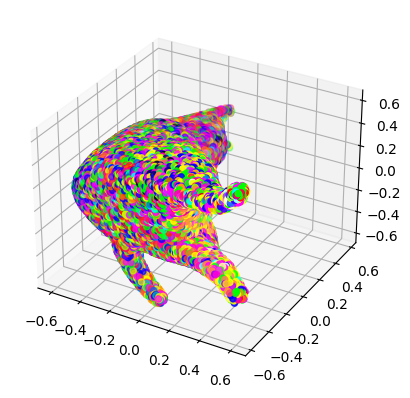

In [295]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xyz[: , 0].detach().numpy(), xyz[: , 1].detach().numpy(), xyz[: , 2].detach().numpy(), c=torch.clamp(rgb.detach(), 0, 1).numpy())
plt.show()

In [296]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz.detach().numpy())
pcd.colors = o3d.utility.Vector3dVector(torch.clamp(rgb.detach(), 0, 1).numpy())
o3d.visualization.draw_plotly([pcd], 
                              up = [0, 1, 0],
                              front = [0, 0, 1], 
                              lookat = [0.0, 0.1, 0.0], 
                              zoom=1,)

# 4. Class per class zero shot classification analysis

Results are manually loaded from the log files on github results https://github.com/Ugo-Insalaco/Uni3D

In [8]:
import numpy as np

In [9]:
classes = "die,crouton,airplane,calculator,doormat,wolf,blanket,brass_plaque,pinwheel,lion,saucer,first-aid_kit,flagpole,jewelry,sunhat,turtle,sail,blackboard,printer,soap,yacht,shark,awning,cone,gourd,toast_(food),sponge,mail_slot,rifle,octopus_(animal),atomizer,pinecone,salmon_(food),mammoth,cookie,birthday_cake,toothpick,wheel,vodka,police_cruiser,paperweight,race_car,marker,wine_bucket,vase,leather,mask,cupcake,lamppost,videotape,scraper,place_mat,nutcracker,figurine,windmill,cap_(headwear),ballet_skirt,boat,steak_knife,hamburger,elk,cup,cigar_box,beanie,helicopter,harmonium,tablecloth,paddle,sunglasses,fish,manhole,tinsel,baseball_glove,diaper,sherbert,wineglass,microwave_oven,shoe,jet_plane,hornet,cow,ram_(animal),hardback_book,space_shuttle,teacup,loveseat,piano,dragonfly,water_ski,comic_book,sofa,quiche,beret,dress_hat,urn,grill,earring,chair,tassel,zebra,stop_sign,icecream,blimp,fire_engine,motor_vehicle,sombrero,toy,jeep,crab_(animal),beer_bottle,subwoofer,chocolate_cake,sunflower,heron,date_(fruit),easel,handbag,strawberry,costume,solar_array,pencil,spider,milk,necklace,fireplug,glove,mushroom,seashell,bench,towel_rack,street_sign,pastry,water_jug,keg,license_plate,balloon,puppet,spectacles,globe,mast,pirate_flag,futon,candle,strap,table-tennis_table,pop_(soda),cellular_telephone,cube,car_(automobile),desk,cracker,lettuce,fish_(food),hair_dryer,table,patty_(food),owl,baseball_cap,river_boat,router_(computer_equipment),armchair,keycard,puffin,football_helmet,kitten,shower_head,armoire,cock,laptop_computer,water_gun,hose,milk_can,breechcloth,dartboard,tiger,salad_plate,candy_cane,flower_arrangement,wok,bracelet,coffeepot,record_player,cream_pitcher,dollhouse,motor,walking_cane,television_set,shopping_bag,clock_tower,basketball_backboard,carnation,basketball,bouquet,unicycle,goggles,potato,cargo_ship,backpack,puffer_(fish),dresser,wristlet,shield,statue_(sculpture),spatula,mallet,convertible_(automobile),parrot,pencil_box,card,gemstone,penguin,tobacco_pipe,horse_buggy,cloak,orange_(fruit),dolphin,chinaware,pot,drone,coin,cushion,person,soccer_ball,cornet,clementine,candle_holder,television_camera,grape,cooker,bottle,army_tank,bat_(animal),pear,computer_keyboard,gravestone,elephant,chandelier,crown,scarecrow,compass,fan,snowman,coconut,water_cooler,railcar_(part_of_a_train),bicycle,starfish,knife,newsstand,chalice,sofa_bed,triangle_(musical_instrument),gift_wrap,shirt,teddy_bear,funnel,handcart,beer_can,alcohol,cape,aerosol_can,muffin,curtain,vending_machine,mascot,gameboard,faucet,pocketknife,butterfly,apron,telephone_booth,flowerpot,pocket_watch,fire_extinguisher,lantern,squid_(food),violin,pancake,cart,mattress,halter_top,martini,bridal_gown,bowl,music_stool,wooden_leg,Lego,rat,typewriter,microscope,fishing_rod,seaplane,goat,tank_top_(clothing),pigeon,cabinet,dress,tray,lamp,sweat_pants,dish,thermometer,snake,fighter_jet,penny_(coin),scoreboard,pillow,drum_(musical_instrument),octopus_(food),skateboard,dish_antenna,pole,sheep,spotlight,wreath,bookcase,cake,hog,antenna,log,paintbrush,inhaler,toothbrush,bullet_train,hotplate,bus_(vehicle),telephone,crow,spice_rack,pen,gun,pet,step_stool,saddle_blanket,gasmask,sewing_machine,cat,gargoyle,oil_lamp,reflector,frying_pan,cappuccino,colander,chessboard,shears,kite,water_faucet,dining_table,bowling_ball,pistol,ski_parka,grizzly,tripod,skullcap,omelet,radiator,motorcycle,pony,shower_cap,folding_chair,playpen,wall_socket,notebook,automatic_washer,doorknob,bulletin_board,kennel,projectile_(weapon),nut,beetle,football_(American),trousers,roller_skate,wedding_cake,flag,sandwich,goldfish,piggy_bank,cassette,walking_stick,combination_lock,crescent_roll,box,mug,slide,lab_coat,dagger,persimmon,machine_gun,koala,radio_receiver,hook,paperback_book,bed,water_bottle,hammer,banana,washbasin,guitar,ladder,pipe_bowl,earplug,pitcher_(vessel_for_liquid),seahorse,sword,raincoat,doughnut,pool_table,chopping_board,frog,magazine,edible_corn,control,flash,plume,barrel,thumbtack,painting,pizza,pan_(metal_container),pickup_truck,refrigerator,kettle,bird,trunk,highchair,bedspread,lampshade,can,frisbee,palette,bottle_cap,green_onion,lightbulb,suitcase,birdhouse,lemon,parasol,spear,crabmeat,amplifier,wheelchair,lizard,salmon_(fish),polar_bear,pottery,water_tower,baguet,streetlight,blueberry,musical_instrument,briefcase,Christmas_tree,shot_glass,camera,joystick,umbrella,vest,trash_can,sweatshirt,tag,passport,cab_(taxi),horned_cow,crawfish,swimsuit,bow-tie,clutch_bag,bow_(decorative_ribbons),Ferris_wheel,ferry,glass_(drink_container),bedpan,pug-dog,headset,steering_wheel,book,teapot,bullhorn,watering_can,bamboo,syringe,cast,wardrobe,deer,ladybug,meatball,cabana,jam,wooden_spoon,falcon,peanut_butter,postbox_(public),orange_juice,eggplant,traffic_light,newspaper,telephoto_lens,grits,grocery_bag,carton,ironing_board,baseball_bat,bell_pepper,trench_coat,poster,wrench,golfcart,remote_control,bread-bin,saucepan,cornmeal,cayenne_(spice),eel,armor,calendar,softball,bunk_bed,checkerboard,medicine,salad,giraffe,runner_(carpet),taillight,weathervane,microphone,toilet,pumpkin,jersey,puppy,bath_towel,hot-air_balloon,dress_suit,cocoa_(beverage),phonebook,shaker,tartan,fireplace,shower_curtain,surfboard,vacuum_cleaner,wall_clock,tractor_(farm_equipment),school_bus,ax,underdrawers,horse,train_(railroad_vehicle),trailer_truck,chicken_(animal),toolbox,taco,robe,ladle,rodent,radish,fedora,walrus,tapestry,dollar,beachball,dog,pendulum,gazelle,camcorder,trophy_cup,crate,flashlight,crowbar,steak_(food),sweet_potato,coat_hanger,plate,rhinoceros,jacket,map,passenger_car_(part_of_a_train),dispenser,truffle_(chocolate),hatbox,toothpaste,fleece,pickle,rocking_chair,goose,flute_glass,kitchen_sink,camel,truck,soup_bowl,power_shovel,nightshirt,helmet,lamb_(animal),freight_car,garden_hose,shopping_cart,road_map,beef_(food),headband,casserole,lemonade,bowler_hat,pencil_sharpener,crib,banner,wine_bottle,sugarcane_(plant),coverall,mixer_(kitchen_tool),sharpener,tow_truck,garbage,Sharpie,stove,stepladder,propeller,platter,key,silo,rib_(food),kitchen_table,dishwasher,eagle,earphone,ferret,ambulance,tricycle,handcuff,watermelon,recliner,hat,coffee_table,artichoke,bow_(weapon),iPod,igniter,egg,sushi,vent,knitting_needle,wedding_ring,rabbit,toaster,doll,choker,strainer,projector,fruit_juice,cistern,alligator,headboard,clock,flip-flop_(sandal),napkin,heart,binder,ashtray,chili_(vegetable),cougar,drumstick,boiled_egg,avocado,mailbox_(at_home),sculpture,tomato,zucchini,flannel,thread,bandanna,dalmatian,booklet,ring,cover,aquarium,cider,alarm_clock,boot,bell,cupboard,sweatband,shawl,rubber_band,cork_(bottle_plug),chocolate_mousse,padlock,burrito,soup,hairnet,beanbag,pineapple,toaster_oven,jar,bear,apple,oar,saddle_(on_an_animal),dumpster,thimble,jumpsuit,hummingbird,identity_card,minivan,passenger_ship,cigarette,pew_(church_bench),magnet,foal,table_lamp,kimono,gull,prune,duckling,water_heater,sausage,tiara,basket,carrot,cornice,award,sawhorse,string_cheese,monitor_(computer_equipment) computer_monitor,stapler_(stapling_machine),boom_microphone,checkbook,sleeping_bag,watch,pea_(food),vinegar,skewer,bread,cockroach,parking_meter,camera_lens,air_conditioner,quilt,crutch,slipper_(footwear),kayak,bobbin,nailfile,wig,broach,deadbolt,motor_scooter,smoothie,Rollerblade,cooler_(for_food),turnip,clipboard,receipt,hippopotamus,sparkler_(fireworks),liquor,scrubbing_brush,brassiere,food_processor,salami,condiment,latch,file_cabinet,signboard,measuring_stick,bulletproof_vest,diary,jewel,monkey,hot_sauce,sink,brussels_sprouts,mandarin_orange,headlight,pelican,tachometer,speaker_(stero_equipment),stool,birdfeeder,coatrack,cherry,tape_(sticky_cloth_or_paper),eclair,peach,camper_(vehicle),forklift,sugar_bowl,pie,lawn_mower,pan_(for_cooking),timer,wristband,skirt,clarinet,brownie,hairbrush,clothespin,banjo,dog_collar,footstool,gondola_(boat),cylinder,ball,sportswear,milestone,snowmobile,lime,mallard,coat,perfume,elevator_car,phonograph_record,spoon,chopstick,domestic_ass,scarf,straw_(for_drinking),ping-pong_ball,cooking_utensil,stagecoach,bathtub,parachute,thermos_bottle,paper_towel,teakettle,cincture,tinfoil,notepad,birdcage,headstall_(for_horses),shovel,visor,barrow,crayon,gorilla,clothes_hamper,whipped_cream,locker,cardigan,bass_horn,handsaw,nest,baseball,dirt_bike,cucumber,blouse,giant_panda,flamingo,pitchfork,bulldozer,cigarette_case,chaise_longue,garbage_truck,canister,wet_suit,cantaloup,mousepad,lasagna,legging_(clothing),ginger,sweater,tote_bag,corset,puncher,sock,pipe,stylus,turkey_(food),crucifix,tennis_ball,dumbbell,postcard,baby_buggy,prawn,waffle,mop,wagon,cleat_(for_securing_rope),mouse_(computer_equipment),button,matchbox,envelope,cash_register,fork,squirrel,shaver_(electric),mirror,wind_chime,asparagus,hamster,crisp_(potato_chip),calf,arctic_(type_of_shoe),drill,beeper,blackberry,clasp,hourglass,coffee_maker,pita_(bread),milkshake,plastic_bag,bucket,turban,belt,ski,knob,sandal_(type_of_shoe),yogurt,money,shampoo,suit_(clothing),canteen,armband,Tabasco_sauce,coil,saxophone,tux,escargot,drawer,seabird,pouch,snowboard,dishwasher_detergent,bulldog,towel,cauliflower,belt_buckle,toilet_tissue,hand_towel,broom,pliers,legume,pajamas,chocolate_bar,pepper,tights_(clothing),bath_mat,root_beer,chocolate_milk,car_battery,racket,heater,needle,wagon_wheel,corkboard,urinal,duck,parakeet,stereo_(sound_system),window_box_(for_plants),bottle_opener,sled,Dixie_cup,shredder_(for_paper),cowboy_hat,cub_(animal),hammock,freshener,kiwi_fruit,bandage,dishtowel,deck_chair,saddlebag,salsa,bubble_gum,garlic,coloring_material,raft,fume_hood,parka,stirrup,packet,poncho,shoulder_bag,broccoli,cornbread,rag_doll,reamer_(juicer),soupspoon,hinge,overalls_(clothing),binoculars,scissors,birthday_card,birdbath,satchel,mound_(baseball),canoe,pennant,bead,radar,lightning_rod,neckerchief,ski_boot,duffel_bag,dove,golf_club,olive_oil,crossbar,baboon,stirrer,onion,telephone_pole,eraser,CD_player,limousine,hand_glass,mat_(gym_equipment),stew,kilt,blazer,can_opener,shepherd_dog,tank_(storage_vessel),hamper,generator,ice_pack,pretzel,Band_Aid,cleansing_agent,cymbal,oven,ham,business_card,life_buoy,gargle,dustpan,parasail_(sports),life_jacket,ostrich,almond,tape_measure,gelatin,Bible,pegboard,ottoman,detergent,tennis_racket,barbell,jean,headscarf,billboard,quesadilla,plow_(farm_equipment),screwdriver,boxing_glove,waffle_iron,melon,honey,short_pants,peeler_(tool_for_fruit_and_vegetables),horse_carriage,egg_roll,anklet,handle,corkscrew,lip_balm,wallet,battery,veil,gravy_boat,paper_plate,turtleneck_(clothing),tortilla,manger,raspberry,chime,polo_shirt,trampoline,butter,cruise_ship,knee_pad,tequila,crape,tarp,volleyball,papaya,scale_(measuring_instrument),suspenders,hockey_stick,apricot,cabin_car,vulture,egg_yolk,hookah,bob,flap,dishrag,barge,coaster,mint_candy,underwear,rearview_mirror,bookmark,fishbowl,knocker_(on_a_door),soya_milk,ski_pole,poker_(fire_stirring_tool),parchment,bun,lollipop,cufflink,bathrobe,tongs,dinghy,shaving_cream,saltshaker,tissue_paper,necktie,blender,ice_maker,tambourine,fire_hose,green_bean,fire_alarm,popsicle,bolt,safety_pin,pudding,handkerchief,clip,bagel,buoy,water_scooter,cowbell"
classes = np.array(classes.split(','))
print(len(classes))
top1 = "0.8148148148148148,0.0,0.9310344827586207,0.5454545454545454,0.4166666666666667,0.5909090909090909,0.0,0.6,0.5,0.8260869565217391,0.6153846153846154,0.2857142857142857,0.1111111111111111,0.13333333333333333,0.4,0.9375,0.6428571428571429,0.0,0.0,0.0,0.42857142857142855,0.8333333333333334,0.2777777777777778,0.9428571428571428,0.07692307692307693,0.2222222222222222,0.9230769230769231,0.08333333333333333,0.8076923076923077,0.4,0.2,0.5454545454545454,0.0,0.14285714285714285,0.3333333333333333,0.8333333333333334,0.0,1.0,0.0,0.8275862068965517,0.0,0.6190476190476191,0.0,0.0,0.7692307692307693,0.0,0.6470588235294118,0.7857142857142857,0.9583333333333334,0.0,0.07142857142857142,0.0,0.3333333333333333,0.25,0.9565217391304348,0.42857142857142855,0.0,0.46153846153846156,0.25,1.0,0.2857142857142857,0.17647058823529413,0.3333333333333333,0.0,0.9655172413793104,0.25,0.92,0.0,0.9375,0.7222222222222222,0.8076923076923077,0.0,0.25,0.25,0.0,1.0,0.625,0.875,0.09090909090909091,0.3333333333333333,0.42857142857142855,0.0,0.29411764705882354,0.6842105263157895,0.125,0.1,0.84,0.5454545454545454,0.0,0.0,0.42857142857142855,0.0,0.0,0.0,0.4444444444444444,0.0,0.5,0.7752808988764045,0.375,0.4,0.7857142857142857,0.8125,0.6153846153846154,0.2,0.047619047619047616,0.15384615384615385,0.15789473684210525,0.8333333333333334,0.8888888888888888,0.6111111111111112,0.3076923076923077,0.1875,0.75,0.0,0.0,0.7777777777777778,0.5,0.375,0.125,0.7777777777777778,0.9230769230769231,0.7727272727272727,0.25,0.7333333333333333,0.9545454545454546,0.8333333333333334,0.9428571428571428,0.6962025316455697,0.9565217391304348,0.16666666666666666,0.36363636363636365,0.0,0.18181818181818182,0.13333333333333333,0.0,0.42857142857142855,0.25,0.2,0.8518518518518519,0.0,0.0,0.0,0.5,0.0,0.6666666666666666,0.18181818181818182,0.5833333333333334,0.6875,0.23809523809523808,0.7222222222222222,0.0,0.5,0.058823529411764705,0.5,0.6086956521739131,0.058823529411764705,0.6896551724137931,0.9375,0.0,0.6666666666666666,0.7894736842105263,0.5,0.14285714285714285,0.25,0.2916666666666667,0.6666666666666666,0.7857142857142857,0.07142857142857142,0.8181818181818182,0.36363636363636365,0.0,0.0,0.0,0.4444444444444444,0.7857142857142857,0.6666666666666666,0.375,0.5217391304347826,0.0,0.7857142857142857,0.21428571428571427,0.5384615384615384,0.0,0.6153846153846154,0.6,0.0,0.9285714285714286,0.2222222222222222,0.8571428571428571,0.7142857142857143,0.375,0.23529411764705882,0.4166666666666667,0.0,0.6363636363636364,0.2857142857142857,0.25,0.8888888888888888,0.1111111111111111,0.7222222222222222,0.0,0.9259259259259259,0.8125,0.6666666666666666,0.21428571428571427,0.4166666666666667,0.7272727272727273,0.0,0.4444444444444444,0.8333333333333334,0.9473684210526315,0.6666666666666666,0.14285714285714285,0.18181818181818182,0.5,0.875,0.25,0.25,0.85,0.7058823529411765,0.0,0.35714285714285715,0.7567567567567568,0.16666666666666666,0.0,0.4090909090909091,0.0,0.42857142857142855,0.2727272727272727,0.2727272727272727,0.7222222222222222,0.7647058823529411,0.8333333333333334,0.88,0.9285714285714286,0.8666666666666667,0.9285714285714286,0.8,0.16666666666666666,0.5,0.9655172413793104,0.9393939393939394,0.0,0.16666666666666666,0.2857142857142857,1.0,0.8666666666666667,0.6896551724137931,0.6363636363636364,0.5714285714285714,0.2727272727272727,0.8,0.85,0.6666666666666666,0.8421052631578947,0.0,1.0,0.2,0.0,0.125,1.0,0.3,0.6,0.8095238095238095,0.041666666666666664,0.21428571428571427,0.7,0.4,0.75,0.0,0.6153846153846154,0.5625,0.625,1.0,0.65,0.5,0.7727272727272727,0.4,0.1,0.5,0.0,0.16666666666666666,0.07692307692307693,1.0,0.0,0.2,0.6875,0.47368421052631576,0.5,0.75,0.5714285714285714,0.42857142857142855,0.25,0.09090909090909091,0.125,0.0,0.7368421052631579,0.36363636363636365,0.06666666666666667,0.0,0.0,0.0,0.7058823529411765,0.8181818181818182,0.2,0.0,0.5714285714285714,0.7,0.125,0.8620689655172413,0.6666666666666666,0.16666666666666666,0.375,0.0,0.4,0.7142857142857143,0.2727272727272727,0.4782608695652174,0.02702702702702703,0.8125,0.25,0.25,0.5,0.0,0.42857142857142855,0.7777777777777778,0.8064516129032258,0.42857142857142855,0.2222222222222222,0.5555555555555556,0.19047619047619047,0.07692307692307693,0.0,0.0,0.75,1.0,0.6363636363636364,0.3684210526315789,0.875,0.0,0.5,0.125,0.25,0.8571428571428571,0.0,0.0,0.45,0.85,0.625,0.875,0.3,0.3157894736842105,0.6363636363636364,0.0,0.16666666666666666,0.6666666666666666,0.8333333333333334,0.9090909090909091,0.0,1.0,0.1111111111111111,0.6666666666666666,0.0,0.6666666666666666,0.2,0.0,0.0,0.375,0.14285714285714285,0.5,0.4444444444444444,0.8,0.5,0.0,0.8333333333333334,0.7857142857142857,0.5,0.875,0.75,0.0,0.42857142857142855,0.5,0.15,0.9090909090909091,0.7142857142857143,0.0,0.2222222222222222,0.16666666666666666,0.5172413793103449,0.8,0.4166666666666667,0.8,0.6666666666666666,0.8,0.7142857142857143,1.0,0.9666666666666667,0.07142857142857142,0.9666666666666667,0.8235294117647058,0.2857142857142857,0.5,0.14285714285714285,0.8333333333333334,0.8055555555555556,0.0,0.9696969696969697,0.7,0.5,0.8571428571428571,0.0,0.5,0.0,0.0,0.2222222222222222,0.9285714285714286,0.0,0.21428571428571427,0.631578947368421,0.1,0.9523809523809523,1.0,0.0,0.4117647058823529,0.7037037037037037,0.4,0.06666666666666667,0.5652173913043478,0.7142857142857143,0.125,1.0,0.0,0.0,0.6666666666666666,0.7142857142857143,0.9,0.3333333333333333,0.6666666666666666,0.5714285714285714,0.0,0.4,0.9090909090909091,0.6363636363636364,0.5,0.3333333333333333,0.14285714285714285,0.8,0.0,0.2222222222222222,0.5,0.15384615384615385,0.3333333333333333,0.8666666666666667,0.25,0.5882352941176471,0.6666666666666666,0.6666666666666666,0.0,0.6875,0.4,0.0,0.0,0.0,0.5714285714285714,0.25,0.4166666666666667,0.0,0.2,0.0,1.0,0.3333333333333333,0.0,0.25,0.125,0.8636363636363636,0.5384615384615384,0.125,1.0,0.4,0.2222222222222222,0.0,1.0,0.0,0.2222222222222222,0.6923076923076923,0.2222222222222222,0.0,0.5,0.0,0.7142857142857143,0.0,0.5,0.6666666666666666,0.0,0.25,0.9375,0.2727272727272727,0.0,0.0,0.25,0.4,0.0,0.9285714285714286,0.16666666666666666,0.5,0.0,1.0,0.375,0.8333333333333334,0.0,0.625,0.0,0.0,0.3333333333333333,0.5945945945945946,0.0,0.0,0.6666666666666666,0.16666666666666666,0.18181818181818182,0.25,0.9230769230769231,0.1111111111111111,0.0,0.16666666666666666,0.5333333333333333,0.9230769230769231,0.9583333333333334,0.0,0.22727272727272727,0.0,0.7,0.0,0.14285714285714285,0.0,0.0,0.0,0.85,0.0,0.2727272727272727,0.2857142857142857,0.5882352941176471,0.42857142857142855,0.5625,0.9,0.0,0.7857142857142857,0.8,0.75,0.7142857142857143,0.2857142857142857,0.0,0.0,0.2,0.0,0.4,0.13333333333333333,1.0,0.3,0.0,0.42857142857142855,0.3888888888888889,0.14285714285714285,0.0,0.5833333333333334,0.5384615384615384,1.0,0.6666666666666666,1.0,0.0,0.25,0.75,0.06666666666666667,0.5714285714285714,0.75,0.3,0.0,0.2,0.0,0.0,0.5,0.0,0.0,1.0,0.5714285714285714,0.0,0.23076923076923078,0.7,0.4444444444444444,0.1,0.5,1.0,0.9,0.125,0.0,0.0,0.8333333333333334,0.0,0.0,0.0,0.25,0.0,0.1111111111111111,0.0,0.6666666666666666,0.0,0.6,0.25,0.25,0.2222222222222222,0.0,0.3333333333333333,0.15384615384615385,0.0,0.2857142857142857,0.15384615384615385,0.75,0.0,0.8823529411764706,0.4,0.2,0.0,0.0,0.42857142857142855,0.2631578947368421,0.25,0.5833333333333334,0.6666666666666666,0.5,0.15384615384615385,0.2857142857142857,0.16666666666666666,0.0,0.25,0.75,0.75,0.0,0.5,0.6,0.25,0.0,0.16,0.875,0.25,0.5555555555555556,0.0,0.0,0.0,0.0,0.0,0.6666666666666666,0.2,0.5714285714285714,0.42857142857142855,0.3333333333333333,0.9117647058823529,0.2,0.0,0.0,0.3333333333333333,0.14285714285714285,0.0,0.5,0.3333333333333333,0.0,0.6,0.0,0.0,0.0,0.5,0.4,0.42857142857142855,0.8125,0.0,0.5555555555555556,0.0,0.6428571428571429,0.8571428571428571,0.8666666666666667,0.0,0.0,0.0,0.3333333333333333,0.0,0.0,1.0,0.25,0.14285714285714285,0.0,0.2857142857142857,0.7333333333333333,0.14285714285714285,0.5714285714285714,0.6666666666666666,0.8947368421052632,0.0,0.5,1.0,0.0,0.16666666666666666,0.3333333333333333,0.0,0.7142857142857143,0.0,0.3333333333333333,0.1,0.0,0.0,0.4375,0.3,0.0,0.0,0.3125,0.7692307692307693,0.5,0.0,0.8,0.5714285714285714,0.7,0.058823529411764705,0.25,0.0,0.92,1.0,0.0,0.0,0.0,0.8076923076923077,0.0,0.0,0.0,0.6666666666666666,0.0,0.5,0.0,0.2222222222222222,0.14285714285714285,0.0,0.2,0.0,0.0,0.3333333333333333,0.7777777777777778,0.0,0.0,0.7368421052631579,0.0,0.0,0.0,0.0,0.5,0.0,0.6666666666666666,0.4,0.1,0.0,0.0,0.0,0.0,0.0,0.16666666666666666,0.5,0.07692307692307693,0.0,0.0,0.0,0.14285714285714285,0.8461538461538461,0.0,1.0,0.2,0.2,0.0,0.0,0.2,0.2857142857142857,0.5833333333333334,0.1,0.16666666666666666,0.4,0.0,0.3333333333333333,0.25,0.5,0.5714285714285714,0.0,0.375,0.3333333333333333,0.5,0.15384615384615385,0.3333333333333333,0.14285714285714285,0.0,0.0,0.6666666666666666,0.0,0.4,0.0,0.0,0.0,0.15384615384615385,0.5454545454545454,0.36363636363636365,0.42857142857142855,0.3333333333333333,0.14285714285714285,0.25,0.16666666666666666,0.5,0.0,0.625,0.8333333333333334,0.3333333333333333,0.0,0.2,0.5,0.0,0.3333333333333333,0.0,0.4,0.0,0.7,0.0,0.0,0.0,0.125,0.0,1.0,0.0,0.7142857142857143,0.0,0.1,0.16666666666666666,0.6153846153846154,0.0,0.5,0.5,0.0,0.2857142857142857,0.5,0.0,0.2,0.2631578947368421,0.0,0.18181818181818182,0.5833333333333334,1.0,0.5,0.6666666666666666,0.3333333333333333,0.14285714285714285,0.125,0.6,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.5,0.0,0.0,0.6666666666666666,0.5714285714285714,0.0,0.0,0.625,0.5,0.6666666666666666,0.0,1.0,0.2,0.16666666666666666,0.0,0.4,0.0,0.625,0.0,0.5,0.16666666666666666,0.8,0.6666666666666666,0.5,0.6666666666666666,0.6153846153846154,0.6666666666666666,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.8333333333333334,0.375,0.0,0.8,0.0,0.75,0.0,0.0,0.0,0.0,0.625,0.6666666666666666,0.0,0.4,0.4444444444444444,0.4,0.16666666666666666,0.25,0.7777777777777778,0.0,0.14285714285714285,0.75,0.09090909090909091,0.25,0.0,0.3333333333333333,0.0,0.25,0.0,0.8,0.0,0.16666666666666666,0.0,1.0,1.0,0.0,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.5,1.0,0.6666666666666666,0.1111111111111111,0.0,0.16666666666666666,0.25,0.6666666666666666,0.7142857142857143,0.6666666666666666,0.2857142857142857,0.3333333333333333,0.0,0.3333333333333333,1.0,0.0,1.0,0.0,0.6666666666666666,0.5,0.3333333333333333,0.0,0.0,0.6666666666666666,0.0,0.0,0.0,0.2857142857142857,0.25,0.0,0.25,0.0,0.0,0.0,0.14285714285714285,0.2857142857142857,0.4,0.0,0.0,0.0,0.0,1.0,0.5,0.6666666666666666,0.5,0.0,0.6666666666666666,0.0,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.5,0.5,0.16666666666666666,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.2,0.42857142857142855,0.0,0.2222222222222222,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.25,0.0,1.0,0.0,0.4,0.0,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.25,0.6666666666666666,0.6666666666666666,0.0,0.0,1.0,0.6363636363636364,0.0,0.0,0.8,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.25,0.0,0.25,0.5,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.3333333333333333,1.0,0.3333333333333333,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.3333333333333333,0.0,0.0,0.3333333333333333,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.5,0.0,1.0,0.0"
top3 = "1.0,0.0,1.0,0.7272727272727273,0.75,0.7727272727272727,0.3333333333333333,0.6666666666666666,1.0,0.9130434782608695,0.6923076923076923,0.42857142857142855,0.6666666666666666,0.8,0.6,0.9375,0.9285714285714286,0.3333333333333333,0.0,0.125,0.5714285714285714,0.9,0.3888888888888889,0.9428571428571428,0.6153846153846154,0.5555555555555556,0.9230769230769231,0.3333333333333333,0.9230769230769231,0.9,0.6,0.6818181818181818,0.14285714285714285,0.7142857142857143,0.7777777777777778,0.8333333333333334,0.0,1.0,0.23076923076923078,0.8620689655172413,0.0,0.6190476190476191,0.4,0.7857142857142857,0.8461538461538461,0.0,0.8235294117647058,0.9285714285714286,1.0,0.3333333333333333,0.07142857142857142,0.14285714285714285,0.6666666666666666,0.7142857142857143,0.9565217391304348,0.8571428571428571,0.0,0.7692307692307693,1.0,1.0,0.8571428571428571,0.8823529411764706,1.0,0.07692307692307693,1.0,0.5,0.96,0.0,0.9375,0.8888888888888888,0.8461538461538461,0.75,1.0,0.5,0.0,1.0,0.875,1.0,0.8181818181818182,0.6666666666666666,0.6428571428571429,0.1111111111111111,0.8235294117647058,0.8421052631578947,0.125,0.9,0.88,0.9090909090909091,0.0,0.0,1.0,0.0,0.0,0.18181818181818182,0.4444444444444444,0.2857142857142857,0.75,0.9438202247191011,0.625,1.0,0.8571428571428571,0.875,0.6923076923076923,0.6,0.47619047619047616,0.3076923076923077,0.3157894736842105,0.9444444444444444,0.9444444444444444,0.8888888888888888,0.3076923076923077,0.4375,0.9375,0.0,0.5,0.8888888888888888,1.0,0.625,0.125,0.7777777777777778,1.0,0.8636363636363636,0.375,1.0,0.9545454545454546,1.0,0.9714285714285714,0.7215189873417721,0.9565217391304348,0.6666666666666666,1.0,0.6,0.45454545454545453,1.0,0.14285714285714285,0.6666666666666666,0.5,1.0,0.8888888888888888,0.0,0.3333333333333333,0.375,0.5833333333333334,0.0,0.8333333333333334,0.7272727272727273,0.75,0.875,0.7142857142857143,0.8333333333333334,0.0,0.5,0.7058823529411765,0.5,0.9130434782608695,0.8823529411764706,0.7931034482758621,0.9375,0.0,0.6666666666666666,1.0,0.6666666666666666,0.8571428571428571,0.75,0.7083333333333334,0.6666666666666666,1.0,0.6428571428571429,1.0,0.7272727272727273,0.16666666666666666,0.0,0.0,0.5555555555555556,0.9285714285714286,1.0,0.5,0.8695652173913043,0.2,1.0,0.7142857142857143,0.8461538461538461,0.2,0.7692307692307693,0.7,0.75,0.9285714285714286,0.4444444444444444,0.8571428571428571,0.7142857142857143,0.75,0.47058823529411764,0.9166666666666666,0.6666666666666666,0.8181818181818182,0.2857142857142857,0.5,0.8888888888888888,0.2222222222222222,1.0,0.09090909090909091,0.9259259259259259,0.9375,0.6666666666666666,0.9285714285714286,0.5833333333333334,1.0,0.0,0.5555555555555556,0.8333333333333334,1.0,0.6666666666666666,0.5714285714285714,0.36363636363636365,0.6428571428571429,1.0,0.3333333333333333,0.4166666666666667,0.85,0.7647058823529411,0.8571428571428571,0.5,0.7837837837837838,0.3333333333333333,0.0,0.8636363636363636,0.9090909090909091,0.42857142857142855,0.7272727272727273,0.9090909090909091,0.9444444444444444,0.8823529411764706,1.0,0.88,1.0,0.9,1.0,0.8666666666666667,0.8333333333333334,0.5,0.9655172413793104,0.9696969696969697,0.0,0.8333333333333334,0.8571428571428571,1.0,0.9333333333333333,0.9310344827586207,0.7272727272727273,0.8571428571428571,0.7272727272727273,0.8,0.9,0.7777777777777778,0.9210526315789473,0.5,1.0,1.0,0.0,0.25,1.0,0.6,1.0,0.9047619047619048,0.3333333333333333,1.0,0.7,1.0,0.8,0.3333333333333333,0.6923076923076923,0.6875,0.875,1.0,0.95,0.6666666666666666,0.8636363636363636,0.8,0.5,0.5,0.6666666666666666,0.3333333333333333,0.46153846153846156,1.0,0.75,0.6,0.75,0.8947368421052632,0.625,0.75,0.5714285714285714,0.7142857142857143,0.375,0.36363636363636365,0.5,0.2,0.8421052631578947,0.36363636363636365,0.7333333333333333,0.0,0.0,0.0,0.7647058823529411,0.9393939393939394,0.8,0.2,0.7142857142857143,0.7666666666666667,0.5,0.8620689655172413,0.75,0.5,0.5,0.0,0.6,0.8571428571428571,1.0,0.7391304347826086,0.16216216216216217,0.875,0.25,0.5,0.6666666666666666,0.4,0.7142857142857143,0.8333333333333334,0.8064516129032258,0.7142857142857143,0.3333333333333333,0.8888888888888888,0.9047619047619048,0.07692307692307693,0.5555555555555556,0.16666666666666666,1.0,1.0,0.8636363636363636,0.7894736842105263,1.0,0.0,1.0,0.625,0.5,0.8571428571428571,0.6666666666666666,0.2,0.95,0.95,0.625,0.9375,0.3,0.631578947368421,0.9090909090909091,0.0,0.5,0.7777777777777778,0.9444444444444444,1.0,0.5,1.0,0.6666666666666666,0.8888888888888888,0.3333333333333333,0.6666666666666666,0.4,0.0,0.2,0.5,0.14285714285714285,1.0,0.6666666666666666,0.8,1.0,1.0,0.8333333333333334,0.9285714285714286,0.8333333333333334,0.9375,0.75,0.6666666666666666,0.8571428571428571,0.6,0.9,1.0,0.7142857142857143,0.0,1.0,0.6666666666666666,0.7931034482758621,1.0,0.7083333333333334,1.0,1.0,0.9333333333333333,0.9285714285714286,1.0,1.0,0.21428571428571427,1.0,1.0,0.7142857142857143,1.0,0.7857142857142857,1.0,0.9444444444444444,0.0,1.0,0.9,0.5625,0.9285714285714286,0.0,0.5,0.6285714285714286,0.125,0.3333333333333333,1.0,0.0,0.42857142857142855,0.7368421052631579,0.3,1.0,1.0,0.5882352941176471,0.7058823529411765,0.8518518518518519,0.8,0.4666666666666667,0.8695652173913043,1.0,0.25,1.0,0.375,0.75,0.75,0.8571428571428571,1.0,0.3333333333333333,0.8888888888888888,0.7142857142857143,0.7272727272727273,0.8,1.0,0.9090909090909091,0.8333333333333334,0.4444444444444444,0.7142857142857143,1.0,0.0,0.8888888888888888,0.5,0.5384615384615384,0.8888888888888888,0.8666666666666667,0.25,0.9411764705882353,0.8666666666666667,1.0,0.16666666666666666,0.875,0.6,0.0,0.3333333333333333,0.3333333333333333,0.7857142857142857,0.5,0.8333333333333334,0.0,0.6,0.0,1.0,0.5,0.2,0.75,0.375,0.8636363636363636,0.6923076923076923,0.875,1.0,0.6,0.3333333333333333,0.6,1.0,0.0,0.7777777777777778,0.8461538461538461,0.8888888888888888,0.0,0.6666666666666666,0.0,0.8571428571428571,0.125,0.5,1.0,0.125,0.75,0.9375,0.36363636363636365,0.16666666666666666,0.0,0.5,0.6,0.0,0.9285714285714286,0.16666666666666666,0.6666666666666666,0.3333333333333333,1.0,0.5,0.8333333333333334,0.0,0.875,0.0,0.0,0.8333333333333334,0.8918918918918919,0.25,0.0,0.75,0.5833333333333334,0.2727272727272727,0.25,0.9230769230769231,0.6666666666666666,0.0,0.16666666666666666,0.6666666666666666,0.9230769230769231,1.0,1.0,0.45454545454545453,0.0,0.9,0.09090909090909091,0.14285714285714285,1.0,0.0,0.0,0.9,0.42857142857142855,0.6363636363636364,0.42857142857142855,0.7058823529411765,1.0,0.6875,0.9,0.0,0.9285714285714286,0.8,0.875,0.8571428571428571,0.7142857142857143,0.0,0.2857142857142857,0.6,0.4,0.8,0.7333333333333333,1.0,1.0,0.25,0.5714285714285714,0.6111111111111112,0.2857142857142857,0.8571428571428571,0.9166666666666666,0.7692307692307693,1.0,0.6666666666666666,1.0,0.2857142857142857,0.75,0.75,0.4666666666666667,0.8571428571428571,1.0,0.4,0.7142857142857143,0.4,0.1111111111111111,0.0,0.5,0.0,0.2,1.0,0.8571428571428571,0.25,1.0,0.9,0.7777777777777778,0.7,0.8333333333333334,1.0,0.95,0.75,0.3,0.0,0.9166666666666666,0.0,0.0,1.0,0.25,0.0,0.3333333333333333,0.0,0.6666666666666666,0.0,0.9,0.5,0.5833333333333334,0.5555555555555556,0.0,0.3333333333333333,0.3076923076923077,0.25,0.5714285714285714,0.8461538461538461,0.875,0.6,0.8823529411764706,0.8,0.4,0.36363636363636365,0.6,0.6428571428571429,1.0,0.75,0.8333333333333334,1.0,0.5,0.3076923076923077,0.7142857142857143,0.4166666666666667,0.4,0.75,1.0,0.75,0.0,0.9,0.8,0.25,0.6666666666666666,0.96,0.875,0.25,0.8888888888888888,0.75,0.0,0.5,0.0,0.2,0.8888888888888888,0.4,0.5714285714285714,1.0,0.6666666666666666,0.9411764705882353,0.2,0.1111111111111111,0.3333333333333333,0.6666666666666666,0.2857142857142857,0.75,0.75,0.6666666666666666,0.7647058823529411,0.7,0.3333333333333333,0.0,0.0,1.0,0.4,0.7142857142857143,0.96875,0.0,0.7777777777777778,0.0,0.7142857142857143,0.8571428571428571,0.8666666666666667,0.5555555555555556,0.0,0.3333333333333333,0.6666666666666666,0.2857142857142857,0.0,1.0,0.5,0.2857142857142857,0.3333333333333333,0.2857142857142857,0.8,0.5714285714285714,0.5714285714285714,1.0,1.0,0.3333333333333333,0.75,1.0,0.5,0.6666666666666666,0.5,0.16666666666666666,0.8571428571428571,1.0,0.6666666666666666,0.8,0.0,0.6666666666666666,0.875,0.4,0.0,0.0,0.875,1.0,0.875,0.8333333333333334,0.8,0.7142857142857143,0.8,0.47058823529411764,0.25,1.0,0.96,1.0,0.6923076923076923,0.0,0.0,0.8076923076923077,0.0,0.0,0.0,0.7777777777777778,0.4,0.5,0.75,0.3333333333333333,0.42857142857142855,1.0,0.8,0.25,0.0,0.3333333333333333,1.0,0.6666666666666666,0.6,0.8947368421052632,0.2857142857142857,0.0,0.0,0.5,0.5,0.0,0.8333333333333334,0.5,0.3,0.0,0.0,0.0,0.0,0.0,0.8333333333333334,0.8333333333333334,0.38461538461538464,0.0,0.25,0.3333333333333333,0.2857142857142857,1.0,0.25,1.0,0.4,0.4,0.0,0.5,0.2,0.42857142857142855,0.8333333333333334,0.4,0.3333333333333333,0.6,0.0,0.6666666666666666,0.5,1.0,0.8571428571428571,0.0,0.5,0.6666666666666666,1.0,0.23076923076923078,0.6666666666666666,0.5714285714285714,0.0,0.5,0.6666666666666666,0.0,1.0,0.0,1.0,1.0,0.3076923076923077,0.8181818181818182,0.5,0.42857142857142855,0.3333333333333333,0.5714285714285714,0.5,0.6666666666666666,0.5,0.5,0.9375,0.8333333333333334,0.6666666666666666,0.0,0.2,0.5,0.4444444444444444,0.3333333333333333,0.6666666666666666,0.6,0.5,0.8,0.5,1.0,0.0,0.25,0.0,1.0,0.2,1.0,0.25,0.1,0.5,0.8461538461538461,0.2857142857142857,0.75,0.8333333333333334,0.0,0.7142857142857143,0.5,0.25,0.2,0.9473684210526315,0.5,0.8181818181818182,0.75,1.0,0.5,0.6666666666666666,0.3333333333333333,0.2857142857142857,1.0,1.0,0.0,0.0,0.0,0.5,0.625,0.0,0.06666666666666667,0.75,0.0,0.14285714285714285,0.6666666666666666,0.5714285714285714,0.5,1.0,0.75,0.8,0.6666666666666666,0.0,1.0,0.8,0.3333333333333333,0.6666666666666666,0.6,0.75,0.75,0.0,0.75,0.16666666666666666,1.0,0.8333333333333334,0.625,0.6666666666666666,0.6923076923076923,1.0,1.0,0.4,0.0,0.3333333333333333,0.75,0.0,0.75,0.0,0.2,0.8333333333333334,0.875,0.0,0.8,0.0,1.0,0.0,0.5,0.4,0.0,0.625,0.6666666666666666,1.0,0.8,0.6666666666666666,0.6,0.3333333333333333,0.5,0.7777777777777778,0.5,0.2857142857142857,0.75,0.18181818181818182,0.25,0.0,0.3333333333333333,0.0,0.5,0.0,1.0,0.0,0.5,0.0,1.0,1.0,0.5,0.0,0.3333333333333333,0.5,0.8333333333333334,0.0,0.0,0.5,1.0,0.6666666666666666,0.7777777777777778,0.3333333333333333,0.8333333333333334,0.75,0.6666666666666666,0.7142857142857143,0.6666666666666666,0.42857142857142855,1.0,0.5,0.3333333333333333,1.0,0.0,1.0,0.0,1.0,0.5,0.3333333333333333,0.0,0.0,0.8333333333333334,0.0,0.0,1.0,0.5714285714285714,0.25,0.0,0.25,0.0,1.0,0.0,0.14285714285714285,0.5714285714285714,1.0,0.0,0.4,0.2,0.5,1.0,0.75,1.0,0.5,0.0,1.0,0.3333333333333333,0.0,0.6666666666666666,0.25,0.0,0.3333333333333333,0.0,0.0,0.8,0.0,0.5,0.0,0.0,0.4,0.6363636363636364,0.0,0.5,0.625,0.5,0.0,0.5,1.0,0.5,0.0,0.0,0.18181818181818182,0.0,0.4,0.42857142857142855,0.4,0.2222222222222222,0.0,0.6666666666666666,0.0,0.0,0.3333333333333333,0.5,0.25,0.5,1.0,0.0,0.4,0.0,0.0,0.3333333333333333,0.5,0.0,0.3333333333333333,0.2,0.5,1.0,0.6666666666666666,1.0,0.5,0.6666666666666666,1.0,0.7272727272727273,0.0,0.25,0.8,0.3333333333333333,0.0,0.75,0.0,0.0,0.0,0.4,0.0,0.0,0.5,0.0,0.5,0.5,0.0,0.3333333333333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.6,1.0,0.5,1.0,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.3333333333333333,1.0,0.6666666666666666,0.0,0.0,1.0,1.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.25,0.5,0.0,0.0,0.0,1.0,0.3333333333333333,0.0,0.0,0.3333333333333333,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0"
top5 = "1.0,0.0,1.0,0.8181818181818182,0.9166666666666666,0.8181818181818182,0.3333333333333333,0.8666666666666667,1.0,0.9565217391304348,0.6923076923076923,0.5714285714285714,0.7777777777777778,0.8666666666666667,0.8,1.0,0.9285714285714286,0.5555555555555556,0.0,0.25,0.7142857142857143,0.9333333333333333,0.5,1.0,0.7692307692307693,0.6666666666666666,0.9230769230769231,0.75,0.9230769230769231,0.9,0.8,0.7727272727272727,0.14285714285714285,0.7142857142857143,0.7777777777777778,1.0,0.0,1.0,0.46153846153846156,0.9310344827586207,0.0,0.7142857142857143,0.6666666666666666,0.9285714285714286,0.8846153846153846,0.18181818181818182,0.8529411764705882,1.0,1.0,0.3333333333333333,0.2857142857142857,0.2857142857142857,0.6666666666666666,0.8214285714285714,0.9565217391304348,0.8571428571428571,0.5,0.7692307692307693,1.0,1.0,0.8928571428571429,0.9411764705882353,1.0,0.23076923076923078,1.0,0.5,0.96,0.0,0.9375,0.8888888888888888,0.8461538461538461,0.75,1.0,0.5,0.4,1.0,0.875,1.0,1.0,1.0,0.6428571428571429,0.1111111111111111,0.8823529411764706,0.8947368421052632,0.375,1.0,0.88,0.9090909090909091,0.0,0.2857142857142857,1.0,0.4,0.14285714285714285,0.5454545454545454,0.7777777777777778,0.2857142857142857,0.75,0.9550561797752809,0.625,1.0,0.9285714285714286,0.9375,0.6923076923076923,0.6,0.7142857142857143,0.5384615384615384,0.5789473684210527,1.0,0.9444444444444444,1.0,0.38461538461538464,0.5625,0.9375,0.25,0.5,0.8888888888888888,1.0,0.625,0.25,0.8333333333333334,1.0,1.0,0.625,1.0,0.9545454545454546,1.0,0.9714285714285714,0.759493670886076,0.9565217391304348,0.8333333333333334,1.0,0.6,0.6363636363636364,1.0,0.14285714285714285,0.7142857142857143,0.8333333333333334,1.0,0.8888888888888888,0.25,0.3333333333333333,0.75,0.6666666666666666,0.0,0.8333333333333334,0.8636363636363636,0.8333333333333334,0.9375,0.7619047619047619,0.8333333333333334,0.0,0.5,0.8235294117647058,0.5,0.9130434782608695,0.9411764705882353,0.896551724137931,1.0,0.8333333333333334,0.6666666666666666,1.0,0.6666666666666666,1.0,0.8333333333333334,0.8333333333333334,0.6666666666666666,1.0,0.8571428571428571,1.0,0.7272727272727273,0.6666666666666666,0.4,0.0,0.5555555555555556,0.9285714285714286,1.0,0.5,0.8695652173913043,0.4,1.0,0.8571428571428571,0.8461538461538461,0.4,0.8461538461538461,0.7,1.0,0.9285714285714286,0.6666666666666666,1.0,0.7142857142857143,0.875,0.5882352941176471,1.0,0.6666666666666666,0.9090909090909091,0.42857142857142855,0.625,0.8888888888888888,0.6666666666666666,1.0,0.09090909090909091,0.9259259259259259,1.0,0.6666666666666666,1.0,0.6666666666666666,1.0,0.0,0.5555555555555556,0.8333333333333334,1.0,0.6666666666666666,0.8571428571428571,0.45454545454545453,0.7857142857142857,1.0,0.4166666666666667,0.75,0.85,0.8235294117647058,0.8571428571428571,0.7857142857142857,0.8648648648648649,0.3333333333333333,0.0,0.8636363636363636,0.9090909090909091,0.5714285714285714,0.7272727272727273,0.9090909090909091,0.9444444444444444,0.8823529411764706,1.0,0.88,1.0,0.9,1.0,0.8666666666666667,0.8333333333333334,0.625,0.9655172413793104,0.9696969696969697,0.0,0.8333333333333334,0.8571428571428571,1.0,0.9333333333333333,0.9655172413793104,0.7272727272727273,1.0,0.8181818181818182,0.8,0.9,0.8333333333333334,0.9473684210526315,0.5,1.0,1.0,0.1111111111111111,0.375,1.0,0.6,1.0,0.9047619047619048,0.7083333333333334,1.0,0.8,1.0,0.8,0.3333333333333333,0.7692307692307693,0.6875,0.875,1.0,1.0,0.8333333333333334,0.9545454545454546,0.8,0.8,0.5,1.0,0.3333333333333333,0.6153846153846154,1.0,0.75,0.6,0.8125,0.9473684210526315,0.875,0.875,0.7142857142857143,0.8571428571428571,0.75,0.36363636363636365,0.75,0.9,0.8947368421052632,0.45454545454545453,0.8666666666666667,0.8,0.0,0.0,0.8235294117647058,0.9393939393939394,0.8,0.2,0.7142857142857143,0.8,0.5,0.896551724137931,0.8333333333333334,0.5555555555555556,0.75,0.0,0.8,0.9047619047619048,1.0,0.8260869565217391,0.2702702702702703,0.875,0.25,0.75,0.6666666666666666,0.9,0.8571428571428571,0.8888888888888888,0.8064516129032258,0.7142857142857143,0.7777777777777778,0.8888888888888888,0.9047619047619048,0.23076923076923078,0.7777777777777778,0.5,1.0,1.0,0.8636363636363636,0.8947368421052632,1.0,0.0,1.0,0.75,0.5,0.8571428571428571,0.6666666666666666,0.2,0.95,0.95,0.625,0.9375,0.4,0.7894736842105263,1.0,0.25,0.6666666666666666,0.7777777777777778,0.9444444444444444,1.0,0.5,1.0,0.6666666666666666,0.8888888888888888,0.5555555555555556,0.6666666666666666,0.6,0.125,0.2,0.625,0.42857142857142855,1.0,0.7777777777777778,0.8,1.0,1.0,0.8888888888888888,0.9285714285714286,0.9166666666666666,0.9375,0.75,0.6666666666666666,0.8571428571428571,0.7,0.9,1.0,0.7142857142857143,0.0,1.0,0.6666666666666666,0.8275862068965517,1.0,0.7083333333333334,1.0,1.0,0.9333333333333333,1.0,1.0,1.0,0.21428571428571427,1.0,1.0,0.7142857142857143,1.0,0.8571428571428571,1.0,0.9444444444444444,0.0,1.0,0.9,0.6875,0.9285714285714286,0.0,0.6666666666666666,0.7142857142857143,0.125,0.3333333333333333,1.0,0.0,0.5,0.7894736842105263,0.5,1.0,1.0,0.8823529411764706,0.8235294117647058,0.8888888888888888,0.8,0.8,0.9130434782608695,1.0,0.5,1.0,0.375,1.0,0.75,0.8571428571428571,1.0,0.3333333333333333,1.0,0.7142857142857143,0.8181818181818182,0.8,1.0,0.9090909090909091,0.8333333333333334,0.7777777777777778,0.7619047619047619,1.0,0.0,0.8888888888888888,0.5,0.8461538461538461,1.0,0.9333333333333333,0.75,0.9411764705882353,0.8666666666666667,1.0,0.3333333333333333,0.875,0.7,0.0,0.3333333333333333,0.3333333333333333,0.7857142857142857,0.5,0.8333333333333334,0.0,0.6,0.3333333333333333,1.0,0.8333333333333334,0.6,0.75,0.375,0.8636363636363636,0.6923076923076923,0.875,1.0,0.6,0.4444444444444444,0.6,1.0,0.25,0.7777777777777778,0.9230769230769231,1.0,0.0,0.6666666666666666,0.25,0.8571428571428571,0.25,0.5,1.0,0.25,1.0,0.9375,0.36363636363636365,0.4166666666666667,0.0,0.5,0.6,0.0,0.9285714285714286,1.0,0.75,0.5555555555555556,1.0,0.5,0.9166666666666666,0.3333333333333333,0.875,0.0,0.4,0.8333333333333334,0.918918918918919,0.5,0.25,0.9166666666666666,0.6666666666666666,0.36363636363636365,0.25,0.9230769230769231,1.0,0.0,0.3333333333333333,0.6666666666666666,0.9230769230769231,1.0,1.0,0.5,0.0,0.9,0.2727272727272727,0.2857142857142857,1.0,0.0,0.0,0.95,0.42857142857142855,0.7272727272727273,0.7142857142857143,0.7647058823529411,1.0,0.875,1.0,0.2,1.0,0.8,1.0,0.8571428571428571,0.8571428571428571,0.0,0.7142857142857143,0.8,0.6,0.8,0.8666666666666667,1.0,1.0,0.5,0.5714285714285714,0.7222222222222222,0.42857142857142855,0.8571428571428571,0.9166666666666666,0.7692307692307693,1.0,0.6666666666666666,1.0,0.5714285714285714,0.75,0.75,0.6666666666666666,1.0,1.0,0.5,0.8571428571428571,0.4,0.2222222222222222,0.0,0.5,0.0,0.2,1.0,0.8571428571428571,0.25,1.0,0.9,0.8888888888888888,0.8,0.8333333333333334,1.0,1.0,0.75,0.5,0.3333333333333333,1.0,0.5,0.5384615384615384,1.0,0.5,0.16666666666666666,0.6666666666666666,0.0,0.6666666666666666,0.0,0.9,0.5,0.75,0.8888888888888888,0.0,0.6666666666666666,0.6153846153846154,0.25,0.8571428571428571,1.0,0.875,0.8,0.8823529411764706,1.0,0.4,0.5454545454545454,0.6,0.6428571428571429,1.0,0.75,0.8333333333333334,1.0,0.5,0.46153846153846156,0.8571428571428571,0.75,0.8,1.0,1.0,0.75,0.125,0.9,0.8,0.25,0.6666666666666666,1.0,1.0,0.5,0.8888888888888888,0.75,0.0,0.5,0.125,0.4,0.8888888888888888,0.7,0.5714285714285714,1.0,0.6666666666666666,0.9705882352941176,0.2,0.2222222222222222,0.3333333333333333,0.6666666666666666,0.2857142857142857,1.0,1.0,0.8333333333333334,0.7647058823529411,0.9,0.8333333333333334,0.0,0.0,1.0,0.4,0.7142857142857143,0.96875,0.0,0.8888888888888888,0.42857142857142855,0.8571428571428571,0.8571428571428571,0.8666666666666667,0.7777777777777778,0.0,0.5,1.0,0.5714285714285714,0.25,1.0,0.5,0.42857142857142855,0.6666666666666666,0.42857142857142855,0.8,0.8571428571428571,0.5714285714285714,1.0,1.0,0.3333333333333333,0.75,1.0,0.5,0.8333333333333334,0.8333333333333334,0.16666666666666666,1.0,1.0,0.6666666666666666,0.8,0.0,0.6666666666666666,0.9375,0.6,0.14285714285714285,0.0,0.875,1.0,1.0,1.0,0.8,0.8571428571428571,0.85,0.6470588235294118,0.5,1.0,1.0,1.0,0.6923076923076923,0.0,0.0,0.8846153846153846,0.25,0.0,0.25,0.7777777777777778,0.6,0.75,0.8333333333333334,0.3333333333333333,0.42857142857142855,1.0,0.8,0.375,0.0,0.3333333333333333,1.0,1.0,0.6,1.0,0.42857142857142855,0.0,0.0,0.5,0.5,0.0,1.0,0.6,0.5,0.0,0.3333333333333333,0.0,0.0,0.5,0.8333333333333334,0.8333333333333334,0.38461538461538464,0.16666666666666666,0.75,0.7777777777777778,0.2857142857142857,1.0,1.0,1.0,0.4,0.6,0.0,0.5,0.2,0.42857142857142855,0.9166666666666666,0.4,0.3333333333333333,0.6,0.0,1.0,1.0,1.0,0.8571428571428571,0.0,0.5,1.0,1.0,0.3076923076923077,0.6666666666666666,0.8571428571428571,0.0,0.5,0.8333333333333334,0.0,1.0,0.16666666666666666,1.0,1.0,0.38461538461538464,0.8181818181818182,0.6818181818181818,0.42857142857142855,0.3333333333333333,0.5714285714285714,0.75,0.6666666666666666,0.5,0.5,0.9375,0.8333333333333334,0.6666666666666666,0.0,0.4,0.625,0.7777777777777778,1.0,0.8888888888888888,0.8,1.0,0.8,0.5,1.0,0.0,0.25,0.3333333333333333,1.0,0.4,1.0,0.25,0.4,0.6666666666666666,0.8461538461538461,0.2857142857142857,0.75,0.8333333333333334,0.0,0.7142857142857143,0.5,0.5,0.2,0.9473684210526315,0.75,0.8181818181818182,0.9166666666666666,1.0,1.0,0.6666666666666666,0.3333333333333333,0.5714285714285714,1.0,1.0,0.4,0.25,0.5,1.0,0.75,0.0,0.2,0.875,0.0,0.14285714285714285,1.0,0.5714285714285714,1.0,1.0,0.875,0.9,0.6666666666666666,0.0,1.0,0.8,0.3333333333333333,1.0,1.0,0.75,0.75,0.0,0.75,0.16666666666666666,1.0,0.8333333333333334,0.625,0.6666666666666666,0.6923076923076923,1.0,1.0,0.6,0.0,0.6666666666666666,1.0,0.0,0.75,0.0,0.2,0.8333333333333334,0.875,0.0,0.8,0.0,1.0,0.25,0.5,0.4,0.0,0.75,0.6666666666666666,1.0,0.8,0.7777777777777778,0.8,0.5,0.75,0.8888888888888888,1.0,0.7142857142857143,0.75,0.6363636363636364,0.5,0.0,0.3333333333333333,0.0,1.0,0.0,1.0,0.5,0.5,0.3333333333333333,1.0,1.0,0.5,0.0,0.6666666666666666,1.0,0.8333333333333334,0.5,0.1,0.5,1.0,0.6666666666666666,0.7777777777777778,0.6666666666666666,0.8333333333333334,0.75,0.6666666666666666,0.8571428571428571,0.6666666666666666,0.7142857142857143,1.0,0.5,0.3333333333333333,1.0,0.0,1.0,1.0,1.0,0.5,0.6666666666666666,0.25,0.0,0.8333333333333334,0.2,0.0,1.0,0.5714285714285714,0.25,0.0,0.25,0.0,1.0,0.5,0.14285714285714285,0.5714285714285714,1.0,0.0,0.8,0.4,0.5,1.0,0.75,1.0,0.5,0.6666666666666666,1.0,1.0,0.0,1.0,0.5,0.0,0.3333333333333333,0.0,0.0,1.0,0.6666666666666666,0.5,0.0,0.0,0.6,0.8181818181818182,0.0,1.0,0.625,0.6666666666666666,0.0,0.5,1.0,0.5,0.3333333333333333,0.0,0.18181818181818182,0.0,0.6,0.42857142857142855,0.6,0.3333333333333333,0.0,0.6666666666666666,0.0,0.0,0.6666666666666666,0.5,0.25,0.5,1.0,0.0,0.6,0.25,0.5,0.6666666666666666,0.5,0.0,0.6666666666666666,0.6,0.5,1.0,0.6666666666666666,1.0,0.5,0.6666666666666666,1.0,0.8181818181818182,0.0,0.75,0.8,0.3333333333333333,0.0,1.0,0.0,0.5,0.0,0.6,1.0,0.0,0.5,0.0,0.5,0.5,0.0,0.3333333333333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.6,1.0,0.5,1.0,0.0,0.0,1.0,0.0,0.5,1.0,0.0,0.3333333333333333,1.0,0.6666666666666666,0.0,1.0,1.0,1.0,0.3333333333333333,0.0,0.0,0.2,0.0,0.5,0.5,0.0,0.0,0.0,1.0,0.3333333333333333,0.0,0.0,0.6666666666666666,0.0,1.0,0.0,0.3333333333333333,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.5,1.0,0.0"
tops = [top1, top3, top5]

def split_and_numpy(tops):
    for i in range(len(tops)):
        tops[i] = tops[i].split(',')
        tops[i] = np.array([float(r) for r in tops[i]])
    return tops

tops_names = ['top1', 'top3', 'top5']
tops = split_and_numpy(tops)

1126


In [373]:
k = 50
for name, top in zip(tops_names, tops):
    toptopkind = top.argsort()[-k:]
    toptopk = top[toptopkind]
    toptopkclasses = classes[toptopkind]
    print(name, toptopk, toptopkclasses)

top1 [0.96969697 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ] ['doughnut' 'wrench' 'pliers' 'headscarf' 'car_battery' 'Dixie_cup'
 'shaving_cream' 'syringe' 'cowboy_hat' 'teapot' 'green_bean' 'popsicle'
 'Ferris_wheel' 'safety_pin' 'pudding' 'palette' 'lollipop' 'refrigerator'
 'hookah' 'wheel' 'padlock' 'stapler_(stapling_machine)' 'bowl'
 'sewing_machine' 'wineglass' 'fire_extinguisher' 'aerosol_can' 'handcart'
 'sink' 'bicycle' 'folding_chair' 'life_buoy' 'nightshirt' 'broom'
 'trampoline' 'rocking_chair' 'birdcage' 'crowbar' 'crate' 'flamingo'
 'papay

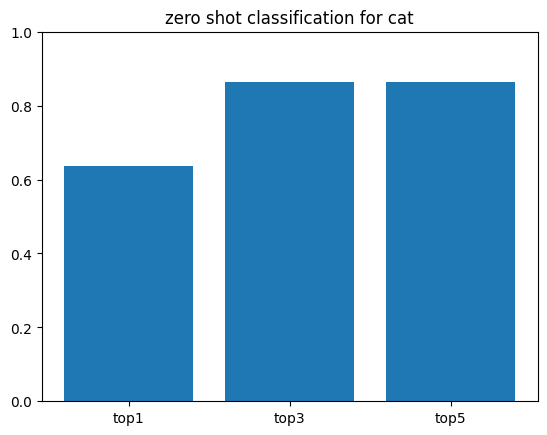

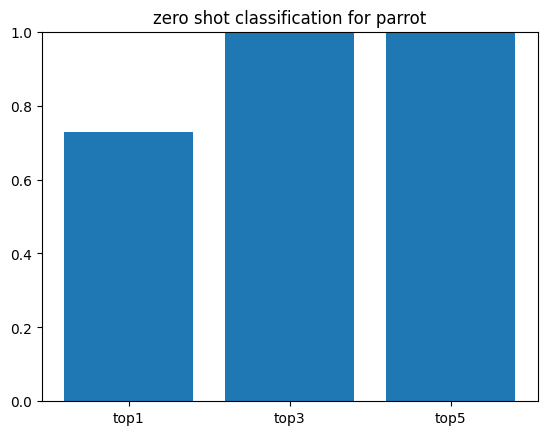

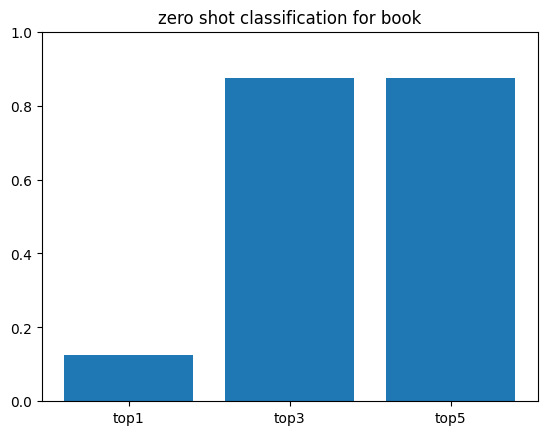

In [392]:
def plot_results(tops, tops_names, results_title):
    cats = np.array(['cat', 'parrot', 'book'])
    catsids = np.array([np.argwhere(classes == c)[0, 0] for c in cats])

    l = []
    for top in tops:
        l.append(top[catsids])

    res = np.stack(l, axis = 1)

    for i in range(len(cats)):
        plt.bar(tops_names,res[i])
        plt.title(f'{results_title} for {cats[i]}')
        plt.ylim(0, 1)
        plt.show()

plot_results(tops, tops_names, 'zero shot classification')

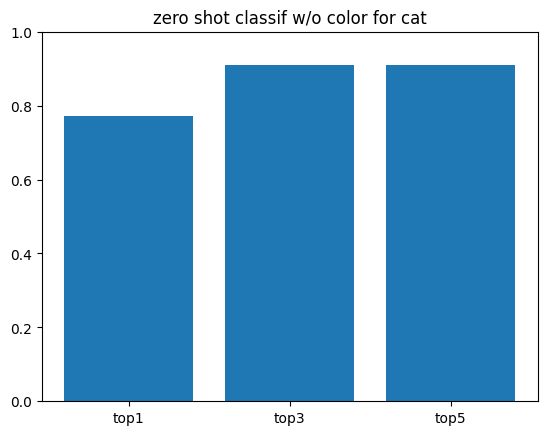

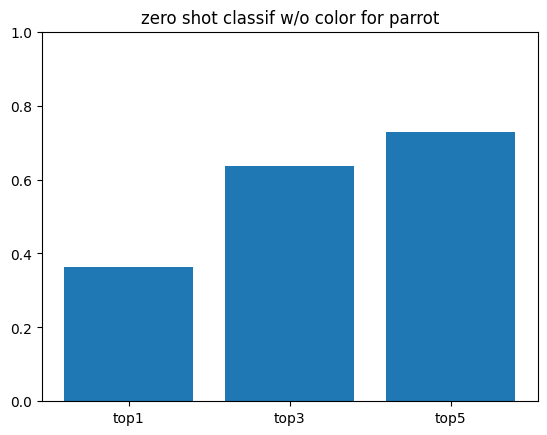

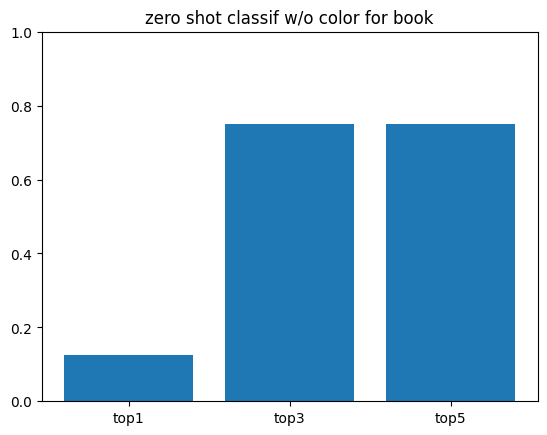

In [393]:
top1nocolor = "0.5185185185185185,0.0,0.9310344827586207,0.5454545454545454,0.25,0.4090909090909091,0.16666666666666666,0.4666666666666667,0.0,0.8695652173913043,0.6153846153846154,0.0,0.1111111111111111,0.2,0.4,0.9375,0.5,0.1111111111111111,0.0,0.125,0.42857142857142855,0.8666666666666667,0.16666666666666666,0.8857142857142857,0.07692307692307693,0.2222222222222222,0.8461538461538461,0.16666666666666666,0.8076923076923077,0.4,0.2,0.5909090909090909,0.0,0.07142857142857142,0.3333333333333333,0.8333333333333334,0.0,1.0,0.0,0.7931034482758621,0.0,0.47619047619047616,0.06666666666666667,0.0,0.7307692307692307,0.0,0.6470588235294118,0.7857142857142857,0.9166666666666666,0.0,0.14285714285714285,0.0,0.16666666666666666,0.17857142857142858,0.9130434782608695,0.2857142857142857,0.0,0.46153846153846156,0.16666666666666666,0.9285714285714286,0.21428571428571427,0.11764705882352941,0.3333333333333333,0.15384615384615385,1.0,0.0,0.88,0.0,0.96875,0.7777777777777778,0.5384615384615384,0.0,0.0,0.0,0.0,1.0,0.5,0.90625,0.09090909090909091,0.3333333333333333,0.42857142857142855,0.1111111111111111,0.35294117647058826,0.6842105263157895,0.125,0.2,0.84,0.6363636363636364,0.0,0.0,0.42857142857142855,0.0,0.0,0.0,0.3333333333333333,0.0,0.5,0.8089887640449438,0.25,0.0,0.6428571428571429,0.6875,0.6153846153846154,0.2,0.14285714285714285,0.07692307692307693,0.10526315789473684,0.9444444444444444,0.8888888888888888,0.5555555555555556,0.23076923076923078,0.0625,0.3125,0.0,0.0,0.8888888888888888,0.2,0.25,0.125,0.7222222222222222,0.9230769230769231,0.8181818181818182,0.25,0.8,0.9545454545454546,0.9166666666666666,0.8571428571428571,0.6075949367088608,0.9565217391304348,0.16666666666666666,0.5454545454545454,0.0,0.18181818181818182,0.13333333333333333,0.0,0.42857142857142855,0.3333333333333333,0.24,0.7037037037037037,0.0,0.0,0.0,0.4166666666666667,0.0,0.6666666666666666,0.0,0.6666666666666666,0.8125,0.14285714285714285,0.6666666666666666,0.0,0.5,0.0,0.5,0.6086956521739131,0.0,0.5862068965517241,0.875,0.0,0.5,0.8421052631578947,0.3333333333333333,0.14285714285714285,0.25,0.2916666666666667,0.5,0.7857142857142857,0.14285714285714285,0.7272727272727273,0.18181818181818182,0.16666666666666666,0.0,0.0,0.4444444444444444,0.35714285714285715,0.3333333333333333,0.125,0.30434782608695654,0.0,0.7857142857142857,0.21428571428571427,0.46153846153846156,0.0,0.38461538461538464,0.6,0.25,0.9285714285714286,0.3333333333333333,0.8571428571428571,0.7142857142857143,0.25,0.0,0.4166666666666667,0.0,0.5454545454545454,0.14285714285714285,0.375,0.8888888888888888,0.16666666666666666,0.7222222222222222,0.0,0.9259259259259259,0.75,0.6666666666666666,0.14285714285714285,0.3333333333333333,0.36363636363636365,0.0,0.3333333333333333,0.75,0.8947368421052632,0.3333333333333333,0.0,0.18181818181818182,0.07142857142857142,0.875,0.16666666666666666,0.25,0.8,0.7058823529411765,0.38095238095238093,0.21428571428571427,0.5135135135135135,0.16666666666666666,0.0,0.5454545454545454,0.09090909090909091,0.2857142857142857,0.18181818181818182,0.36363636363636365,0.6666666666666666,0.7058823529411765,0.8333333333333334,0.88,0.8214285714285714,0.9,0.9285714285714286,0.8,0.3333333333333333,0.25,0.9310344827586207,0.8787878787878788,0.0,0.0,0.14285714285714285,1.0,0.8,0.6206896551724138,0.5454545454545454,0.5,0.2727272727272727,0.8,0.85,0.6111111111111112,0.7894736842105263,0.0,1.0,0.06666666666666667,0.0,0.125,1.0,0.4,0.6,0.7619047619047619,0.0,0.0,0.7,0.3,0.65,0.0,0.6153846153846154,0.5625,0.625,1.0,0.6,0.3333333333333333,0.7727272727272727,0.0,0.1,0.16666666666666666,0.0,0.3333333333333333,0.07692307692307693,0.9375,0.0,0.0,0.625,0.5789473684210527,0.625,0.75,0.42857142857142855,0.42857142857142855,0.125,0.2727272727272727,0.0,0.0,0.7894736842105263,0.36363636363636365,0.13333333333333333,0.0,0.0,0.0,0.7647058823529411,0.8484848484848485,0.0,0.0,0.5714285714285714,0.6,0.125,0.8620689655172413,0.5833333333333334,0.2777777777777778,0.25,0.0,0.4,0.7142857142857143,0.2727272727272727,0.34782608695652173,0.02702702702702703,0.75,0.25,0.0,0.5,0.1,0.42857142857142855,0.7777777777777778,0.7741935483870968,0.14285714285714285,0.1111111111111111,0.6666666666666666,0.2857142857142857,0.07692307692307693,0.0,0.0,0.75,1.0,0.7727272727272727,0.3157894736842105,0.75,0.0,0.5,0.375,0.0,0.8571428571428571,0.0,0.0,0.25,0.9,0.5,0.8125,0.3,0.05263157894736842,0.6363636363636364,0.0,0.0,0.5555555555555556,0.8888888888888888,0.9090909090909091,0.0,1.0,0.1111111111111111,0.5555555555555556,0.1111111111111111,0.5555555555555556,0.0,0.0,0.0,0.3125,0.0,0.75,0.0,0.8,0.5,0.0,0.7777777777777778,0.5714285714285714,0.3333333333333333,0.6875,0.5833333333333334,0.3333333333333333,0.0,0.5,0.25,0.9090909090909091,0.5714285714285714,0.0,0.3333333333333333,0.0,0.3793103448275862,0.4,0.2916666666666667,1.0,0.6666666666666666,0.9333333333333333,0.5,1.0,0.8666666666666667,0.07142857142857142,0.8,0.7647058823529411,0.5714285714285714,0.5,0.14285714285714285,0.8333333333333334,0.8611111111111112,0.0,0.9696969696969697,0.6,0.4375,0.7857142857142857,0.0,0.3333333333333333,0.02857142857142857,0.0,0.2222222222222222,0.9285714285714286,0.0,0.42857142857142855,0.21052631578947367,0.0,0.9523809523809523,1.0,0.0,0.17647058823529413,0.6666666666666666,0.4,0.2,0.43478260869565216,0.7142857142857143,0.125,1.0,0.0,0.0,0.6666666666666666,0.5714285714285714,0.9,0.0,0.5555555555555556,0.5714285714285714,0.0,0.3,0.9090909090909091,0.5454545454545454,0.6666666666666666,0.0,0.09523809523809523,0.8,0.0,0.1111111111111111,0.0,0.15384615384615385,0.3333333333333333,0.8666666666666667,0.25,0.6470588235294118,0.6,0.6666666666666666,0.16666666666666666,0.75,0.4,0.0,0.0,0.0,0.5,0.25,0.3333333333333333,0.0,0.2,0.0,0.8888888888888888,0.16666666666666666,0.0,0.5,0.125,0.8636363636363636,0.46153846153846156,0.125,1.0,0.4,0.2222222222222222,0.0,1.0,0.0,0.4444444444444444,0.6923076923076923,0.1111111111111111,0.0,0.6666666666666666,0.0,0.0,0.0,0.0,0.6666666666666666,0.0,0.0,0.8125,0.0,0.0,0.0,0.25,0.2,0.0,0.9285714285714286,0.0,0.4166666666666667,0.0,1.0,0.375,0.5833333333333334,0.3333333333333333,0.75,0.0,0.0,0.5,0.5945945945945946,0.0,0.0,0.8333333333333334,0.08333333333333333,0.2727272727272727,0.25,0.8461538461538461,0.0,0.0,0.16666666666666666,0.5333333333333333,0.9230769230769231,0.9166666666666666,0.0,0.3181818181818182,0.0,0.6,0.0,0.0,1.0,0.0,0.0,0.85,0.0,0.2727272727272727,0.2857142857142857,0.5294117647058824,0.7142857142857143,0.375,0.8,0.0,0.7857142857142857,0.8,0.625,0.2857142857142857,0.14285714285714285,0.0,0.0,0.2,0.0,0.0,0.06666666666666667,1.0,0.4,0.0,0.0,0.2222222222222222,0.14285714285714285,0.42857142857142855,0.4166666666666667,0.46153846153846156,0.5833333333333334,0.6666666666666666,1.0,0.0,0.0,0.75,0.13333333333333333,0.42857142857142855,0.6666666666666666,0.1,0.0,0.2,0.0,0.0,0.5,0.0,0.0,1.0,0.42857142857142855,0.0,0.23076923076923078,0.6,0.5555555555555556,0.1,0.5,0.5,0.9,0.25,0.0,0.0,0.8333333333333334,0.0,0.0,0.0,0.25,0.0,0.1111111111111111,0.0,0.6666666666666666,0.0,0.5,0.25,0.08333333333333333,0.2222222222222222,0.0,0.0,0.15384615384615385,0.0,0.2857142857142857,0.15384615384615385,0.625,0.2,0.8823529411764706,0.4,0.0,0.0,0.0,0.42857142857142855,0.3157894736842105,0.25,0.3333333333333333,0.5,0.5,0.0,0.14285714285714285,0.16666666666666666,0.0,0.25,0.75,0.5,0.0,0.7,0.7,0.25,0.0,0.04,0.875,0.0,0.6666666666666666,0.0,0.0,0.25,0.0,0.0,0.5555555555555556,0.2,0.42857142857142855,0.5714285714285714,0.3333333333333333,0.9117647058823529,0.2,0.0,0.0,0.0,0.0,0.25,0.125,0.3333333333333333,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.5714285714285714,0.84375,0.0,0.4444444444444444,0.0,0.6428571428571429,0.7857142857142857,0.8666666666666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.14285714285714285,0.0,0.42857142857142855,0.7333333333333333,0.14285714285714285,0.42857142857142855,0.6666666666666666,0.8421052631578947,0.0,0.0,0.9444444444444444,0.0,0.5,0.3333333333333333,0.0,0.5714285714285714,0.0,0.0,0.1,0.0,0.16666666666666666,0.4375,0.2,0.0,0.0,0.125,0.6153846153846154,0.125,0.0,0.8,0.2857142857142857,0.7,0.11764705882352941,0.0,0.0,0.96,1.0,0.0,0.0,0.3333333333333333,0.8076923076923077,0.0,0.0,0.0,0.3333333333333333,0.0,0.5,0.0,0.2222222222222222,0.0,0.0,0.2,0.0,0.0,0.3333333333333333,0.6666666666666666,0.0,0.4,0.6842105263157895,0.0,0.0,0.0,0.0,0.0,0.0,0.3333333333333333,0.4,0.1,0.0,0.0,0.0,0.0,0.0,0.16666666666666666,0.5,0.15384615384615385,0.0,0.0,0.0,0.14285714285714285,0.9230769230769231,0.0,1.0,0.0,0.0,0.0,0.0,0.2,0.42857142857142855,0.6666666666666666,0.1,0.16666666666666666,0.4,0.0,0.3333333333333333,0.25,0.5,0.7142857142857143,0.0,0.5,0.3333333333333333,0.5,0.0,0.3333333333333333,0.2857142857142857,0.0,0.0,0.6666666666666666,0.0,0.2,0.0,0.1111111111111111,0.5,0.07692307692307693,0.18181818181818182,0.18181818181818182,0.42857142857142855,0.0,0.0,0.125,0.16666666666666666,0.0,0.0,0.5625,0.6666666666666666,0.3333333333333333,0.0,0.2,0.5,0.0,0.3333333333333333,0.0,0.6,0.25,0.7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.1,0.0,0.6923076923076923,0.14285714285714285,0.25,0.5,0.0,0.42857142857142855,0.5,0.0,0.0,0.2631578947368421,0.0,0.09090909090909091,0.0,0.6,0.5,0.5,0.0,0.2857142857142857,0.125,0.6,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.625,0.0,0.0,0.6666666666666666,0.5714285714285714,0.0,0.0,0.625,0.0,0.6666666666666666,0.0,1.0,0.2,0.16666666666666666,0.0,0.4,0.0,0.75,0.0,0.5,0.0,0.8,0.6666666666666666,0.375,0.6666666666666666,0.38461538461538464,0.3333333333333333,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.8333333333333334,0.375,0.0,0.6,0.0,0.8333333333333334,0.0,0.0,0.0,0.0,0.375,0.6666666666666666,0.0,0.4,0.3333333333333333,0.4,0.3333333333333333,0.0,0.6666666666666666,0.0,0.0,0.75,0.09090909090909091,0.25,0.25,0.3333333333333333,0.0,0.25,0.0,0.8,0.0,0.16666666666666666,0.0,0.75,0.9,0.0,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.0,0.6666666666666666,0.0,0.0,0.0,0.0,0.6666666666666666,0.5714285714285714,0.6666666666666666,0.2857142857142857,0.3333333333333333,0.0,0.3333333333333333,1.0,0.0,1.0,0.0,0.6666666666666666,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.0,0.0,0.0,0.0,0.42857142857142855,0.4,0.0,0.0,0.0,0.0,1.0,0.25,0.6666666666666666,0.5,0.0,0.6666666666666666,0.0,0.0,0.6666666666666666,0.0,0.0,0.0,0.0,0.0,0.4,0.3333333333333333,0.0,0.0,0.0,0.6,0.09090909090909091,0.0,0.5,0.625,0.16666666666666666,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.2,0.42857142857142855,0.0,0.1111111111111111,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.4,0.0,0.0,0.6666666666666666,0.0,0.0,0.3333333333333333,0.0,0.0,0.5,0.6666666666666666,0.6666666666666666,0.0,0.0,1.0,0.45454545454545453,0.0,0.0,0.8,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.5,0.0,0.25,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.3333333333333333,1.0,0.3333333333333333,0.0,0.0,0.3333333333333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.3333333333333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0"
top3nocolor = "0.7407407407407407,0.0,1.0,0.8181818181818182,0.8333333333333334,0.7272727272727273,0.3333333333333333,0.5333333333333333,0.5,0.9565217391304348,0.6153846153846154,0.07142857142857142,0.5555555555555556,0.8,0.6,0.9375,0.9285714285714286,0.2222222222222222,0.0,0.125,0.5714285714285714,0.8666666666666667,0.4444444444444444,0.9428571428571428,0.6923076923076923,0.4444444444444444,0.8461538461538461,0.4166666666666667,0.9230769230769231,0.9,0.4,0.6818181818181818,0.14285714285714285,0.7857142857142857,0.6666666666666666,0.8333333333333334,0.0,1.0,0.15384615384615385,0.896551724137931,0.0,0.6190476190476191,0.4,0.8571428571428571,0.8461538461538461,0.0,0.7647058823529411,0.9285714285714286,1.0,0.2222222222222222,0.21428571428571427,0.2857142857142857,0.3333333333333333,0.6785714285714286,0.9130434782608695,0.8571428571428571,0.0,0.7692307692307693,1.0,0.9285714285714286,0.8214285714285714,0.8823529411764706,0.3333333333333333,0.23076923076923078,1.0,0.25,0.96,0.0,0.96875,0.8888888888888888,0.6538461538461539,0.5,1.0,0.5,0.0,1.0,0.75,1.0,0.9090909090909091,0.6666666666666666,0.6428571428571429,0.3333333333333333,0.9411764705882353,0.8421052631578947,0.125,0.8,0.88,0.8181818181818182,0.0,0.0,1.0,0.0,0.0,0.09090909090909091,0.4444444444444444,0.14285714285714285,0.75,0.9325842696629213,0.375,0.6,0.7142857142857143,0.75,0.6153846153846154,0.2,0.47619047619047616,0.3076923076923077,0.3684210526315789,0.9444444444444444,0.9444444444444444,1.0,0.23076923076923078,0.375,0.6875,0.0,0.0,0.8888888888888888,0.7,0.25,0.125,0.7222222222222222,1.0,0.8636363636363636,0.375,1.0,0.9545454545454546,1.0,0.9142857142857143,0.6455696202531646,0.9565217391304348,0.6666666666666666,0.7272727272727273,0.3,0.45454545454545453,1.0,0.0,0.7619047619047619,0.5,1.0,0.7407407407407407,0.0,0.16666666666666666,0.125,0.5833333333333334,0.0,0.8333333333333334,0.5909090909090909,0.6666666666666666,0.875,0.5714285714285714,0.8333333333333334,0.0,0.5,0.5882352941176471,0.5,0.9130434782608695,0.8823529411764706,0.7241379310344828,1.0,0.0,0.5,1.0,0.5,0.7142857142857143,0.5,0.6666666666666666,0.6666666666666666,1.0,0.6428571428571429,0.8181818181818182,0.45454545454545453,0.5,0.0,0.0,0.4444444444444444,0.7142857142857143,1.0,0.375,0.6086956521739131,0.2,1.0,0.6428571428571429,0.6923076923076923,0.1,0.6153846153846154,0.7,0.75,0.9285714285714286,0.6666666666666666,0.8571428571428571,0.7142857142857143,0.625,0.11764705882352941,0.8333333333333334,0.6666666666666666,0.8181818181818182,0.2857142857142857,0.75,0.8888888888888888,0.2777777777777778,1.0,0.09090909090909091,0.9259259259259259,1.0,0.6666666666666666,0.8571428571428571,0.5833333333333334,0.6363636363636364,0.0,0.6666666666666666,0.9166666666666666,0.9473684210526315,0.6666666666666666,0.2857142857142857,0.36363636363636365,0.35714285714285715,1.0,0.16666666666666666,0.3333333333333333,0.8,0.7647058823529411,0.8571428571428571,0.5714285714285714,0.6216216216216216,0.16666666666666666,0.0,0.7727272727272727,0.9090909090909091,0.2857142857142857,0.5454545454545454,0.9090909090909091,0.9444444444444444,0.8235294117647058,1.0,0.88,0.9285714285714286,0.9,1.0,0.8666666666666667,0.5,0.375,0.9655172413793104,0.9090909090909091,0.2,0.5,0.8571428571428571,1.0,0.8666666666666667,0.896551724137931,0.6363636363636364,0.9285714285714286,0.7272727272727273,0.8,0.85,0.7777777777777778,0.8947368421052632,0.5,1.0,1.0,0.0,0.5,1.0,0.6,1.0,0.8571428571428571,0.125,0.8571428571428571,0.7,0.9,0.8,0.3333333333333333,0.7692307692307693,0.6875,0.75,1.0,0.9,0.6666666666666666,0.8181818181818182,0.6,0.5,0.16666666666666666,0.6666666666666666,0.3333333333333333,0.3076923076923077,1.0,0.75,0.0,0.75,0.8421052631578947,0.75,0.75,0.42857142857142855,0.7142857142857143,0.25,0.36363636363636365,0.5,0.6,0.8947368421052632,0.36363636363636365,0.6,0.0,0.0,0.0,0.7647058823529411,0.8787878787878788,0.8,0.0,0.7142857142857143,0.6666666666666666,0.375,0.8620689655172413,0.75,0.4444444444444444,0.5,0.0,0.4,0.7619047619047619,0.9090909090909091,0.5652173913043478,0.08108108108108109,0.875,0.25,0.0,0.6666666666666666,0.3,0.7142857142857143,0.8333333333333334,0.7741935483870968,0.7142857142857143,0.4444444444444444,0.7777777777777778,0.9047619047619048,0.23076923076923078,0.5555555555555556,0.0,1.0,1.0,0.9090909090909091,0.6842105263157895,1.0,0.0,1.0,0.625,0.5,0.8571428571428571,0.6666666666666666,0.0,0.95,0.95,0.5,0.875,0.3,0.5263157894736842,1.0,0.0,0.0,0.6666666666666666,0.9444444444444444,0.9545454545454546,0.5,1.0,0.7777777777777778,0.5555555555555556,0.4444444444444444,0.6666666666666666,0.4,0.0,0.2,0.625,0.14285714285714285,1.0,0.1111111111111111,0.8,0.5,0.7333333333333333,0.8333333333333334,0.7857142857142857,0.6666666666666666,0.875,0.6666666666666666,0.6666666666666666,0.8571428571428571,0.7,0.85,1.0,0.7142857142857143,0.0,1.0,0.16666666666666666,0.7586206896551724,0.6,0.4583333333333333,1.0,1.0,0.9333333333333333,0.8571428571428571,1.0,0.9333333333333333,0.21428571428571427,0.9666666666666667,1.0,0.7142857142857143,1.0,0.7142857142857143,0.8333333333333334,0.9166666666666666,0.0,0.9696969696969697,0.8,0.5,0.7857142857142857,0.0,0.3333333333333333,0.6285714285714286,0.0,0.2222222222222222,1.0,0.0,0.42857142857142855,0.2631578947368421,0.0,1.0,1.0,0.47058823529411764,0.7058823529411765,0.8148148148148148,0.6,0.7333333333333333,0.8695652173913043,1.0,0.625,1.0,0.25,0.25,0.75,0.8571428571428571,0.9,0.1111111111111111,1.0,0.5714285714285714,0.6363636363636364,0.5,1.0,0.5454545454545454,0.6666666666666666,0.2222222222222222,0.2857142857142857,1.0,0.0,0.8888888888888888,0.0,0.5384615384615384,0.8888888888888888,0.8666666666666667,0.5,0.8823529411764706,0.8,1.0,0.3333333333333333,0.875,0.6,0.0,0.0,0.0,0.7142857142857143,0.5,0.5833333333333334,0.0,0.6,0.0,1.0,0.8333333333333334,0.2,0.5,0.375,0.8636363636363636,0.6923076923076923,0.75,1.0,0.4,0.3333333333333333,0.4,1.0,0.0,0.7777777777777778,0.9230769230769231,0.6666666666666666,0.0,0.6666666666666666,0.5,0.2857142857142857,0.0,0.5,0.8888888888888888,0.0,0.0,0.9375,0.0,0.16666666666666666,0.0,0.5,0.4,0.0,0.9285714285714286,0.3333333333333333,0.6666666666666666,0.4444444444444444,1.0,0.5,0.75,0.3333333333333333,0.875,0.0,0.0,0.8333333333333334,0.7027027027027027,0.5,0.0,0.8333333333333334,0.4166666666666667,0.2727272727272727,0.25,1.0,0.0,0.0,0.3333333333333333,0.6666666666666666,0.9230769230769231,0.9583333333333334,1.0,0.45454545454545453,0.0,0.9,0.09090909090909091,0.0,1.0,0.0,0.0,0.85,0.42857142857142855,0.5454545454545454,0.2857142857142857,0.7058823529411765,1.0,0.5625,0.9,0.0,0.9285714285714286,0.8,0.875,0.5714285714285714,0.42857142857142855,0.0,0.42857142857142855,0.6,0.6,0.4,0.7333333333333333,1.0,0.9,0.0,0.14285714285714285,0.5,0.2857142857142857,1.0,0.9166666666666666,0.5384615384615384,1.0,0.6666666666666666,1.0,0.2857142857142857,0.5,0.75,0.4666666666666667,0.7142857142857143,1.0,0.5,0.7142857142857143,0.6,0.0,0.0,0.5,0.0,0.2,1.0,0.7142857142857143,0.25,0.9230769230769231,0.8,0.8888888888888888,0.6,0.8333333333333334,0.5,0.9,0.75,0.2,0.3333333333333333,0.9166666666666666,0.0,0.0,1.0,0.25,0.0,0.4444444444444444,0.0,0.6666666666666666,0.0,0.9,0.5,0.3333333333333333,0.6666666666666666,0.0,0.3333333333333333,0.46153846153846156,0.25,0.7142857142857143,0.8461538461538461,1.0,0.6,0.8823529411764706,0.8,0.0,0.2727272727272727,0.4,0.6428571428571429,1.0,0.75,0.6666666666666666,1.0,0.5,0.0,0.8571428571428571,0.5,0.4,0.625,1.0,0.75,0.0,1.0,0.7,0.25,0.3333333333333333,0.84,0.875,0.25,0.7777777777777778,0.75,0.0,0.25,0.0,0.2,0.8888888888888888,0.5,0.5714285714285714,0.8571428571428571,0.6666666666666666,0.9117647058823529,0.2,0.1111111111111111,0.0,0.3333333333333333,0.14285714285714285,0.5,0.5,0.3333333333333333,0.7647058823529411,0.2,0.0,0.0,0.0,0.0,0.2,0.5714285714285714,0.96875,0.0,0.8888888888888888,0.14285714285714285,0.6428571428571429,0.8571428571428571,0.8666666666666667,0.6666666666666666,0.0,0.16666666666666666,0.3333333333333333,0.14285714285714285,0.0,1.0,0.25,0.14285714285714285,0.6666666666666666,0.42857142857142855,0.7333333333333333,0.42857142857142855,0.5714285714285714,0.8333333333333334,0.9473684210526315,0.0,0.5,0.9444444444444444,0.0,0.8333333333333334,0.5,0.16666666666666666,0.5714285714285714,0.3333333333333333,0.3333333333333333,0.8,0.0,0.6666666666666666,0.875,0.4,0.0,0.0,0.6875,0.8461538461538461,0.375,0.8333333333333334,0.8,0.5714285714285714,0.8,0.4117647058823529,0.25,0.0,0.96,1.0,0.6153846153846154,0.0,0.6666666666666666,0.8076923076923077,0.0,0.0,0.25,0.6666666666666666,0.6,0.5,0.75,0.3333333333333333,0.14285714285714285,1.0,0.8,0.125,0.0,0.3333333333333333,1.0,0.6666666666666666,0.6,1.0,0.42857142857142855,0.0,0.0,0.5,0.5,0.0,1.0,0.5,0.2,0.0,0.0,0.0,0.0,0.0,0.8333333333333334,0.8333333333333334,0.3076923076923077,0.0,0.25,0.1111111111111111,0.2857142857142857,1.0,0.25,1.0,0.2,0.0,0.0,0.0,0.2,0.5714285714285714,0.75,0.3,0.3333333333333333,0.6,0.0,0.3333333333333333,0.75,1.0,0.8571428571428571,0.0,0.5,0.6666666666666666,1.0,0.07692307692307693,0.6666666666666666,0.8571428571428571,0.0,0.0,0.6666666666666666,0.0,1.0,0.0,1.0,1.0,0.23076923076923078,0.7272727272727273,0.4090909090909091,0.5714285714285714,0.3333333333333333,0.42857142857142855,0.75,0.5,0.5,0.5,0.875,0.6666666666666666,0.6666666666666666,0.0,0.2,0.625,0.0,0.3333333333333333,0.5555555555555556,0.8,1.0,0.7,0.5,1.0,0.0,0.0,0.0,1.0,0.2,1.0,0.25,0.2,0.5,0.7692307692307693,0.2857142857142857,0.75,0.8333333333333334,0.0,0.7142857142857143,0.5,0.25,0.0,0.9473684210526315,0.5,0.7272727272727273,0.08333333333333333,0.8,0.5,0.6666666666666666,0.3333333333333333,0.42857142857142855,1.0,1.0,0.2,0.0,0.0,0.0,0.625,0.0,0.13333333333333333,0.875,0.0,0.14285714285714285,0.6666666666666666,0.5714285714285714,0.3333333333333333,0.5,0.875,0.6,0.6666666666666666,0.0,1.0,0.8,0.3333333333333333,0.6666666666666666,0.8,0.0,0.75,0.0,0.5,0.16666666666666666,0.8,0.8333333333333334,0.375,0.6666666666666666,0.5384615384615384,1.0,1.0,0.0,0.0,0.3333333333333333,0.75,0.0,0.75,0.0,0.2,0.8333333333333334,0.75,0.0,0.8,0.0,1.0,0.0,0.0,0.0,0.0,0.5,0.6666666666666666,0.0,0.4,0.6666666666666666,0.6,0.3333333333333333,0.25,0.8888888888888888,0.5,0.2857142857142857,0.75,0.2727272727272727,0.25,0.25,0.3333333333333333,0.0,0.75,0.0,0.8,0.0,0.3333333333333333,0.3333333333333333,0.75,1.0,0.0,0.0,0.3333333333333333,0.0,0.8333333333333334,0.25,0.0,0.0,1.0,0.6666666666666666,0.4444444444444444,0.0,0.8333333333333334,0.0,0.6666666666666666,0.7142857142857143,0.6666666666666666,0.42857142857142855,1.0,0.5,0.3333333333333333,1.0,0.0,1.0,0.3333333333333333,0.6666666666666666,0.0,0.3333333333333333,0.0,0.0,0.8333333333333334,0.0,0.0,0.5,0.42857142857142855,0.25,0.0,0.25,0.0,0.5,0.0,0.0,0.5714285714285714,1.0,0.0,0.4,0.2,0.0,1.0,1.0,1.0,0.5,0.3333333333333333,1.0,0.3333333333333333,0.0,0.6666666666666666,0.25,0.0,0.3333333333333333,0.0,0.5,0.8,0.3333333333333333,0.3333333333333333,0.0,0.0,0.6,0.6363636363636364,0.0,0.5,0.625,0.3333333333333333,0.0,0.0,1.0,0.5,0.0,0.0,0.18181818181818182,0.0,0.4,0.42857142857142855,0.2,0.3333333333333333,0.0,0.6666666666666666,0.0,0.0,0.0,0.0,0.25,0.5,1.0,0.0,0.6,0.0,0.0,0.6666666666666666,0.0,0.0,0.3333333333333333,0.0,0.0,1.0,0.6666666666666666,1.0,0.5,0.0,1.0,0.45454545454545453,0.5,0.5,0.8,0.3333333333333333,0.0,0.25,0.0,0.0,0.0,0.4,0.0,0.0,0.5,0.0,0.5,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.3333333333333333,1.0,0.3333333333333333,0.0,0.0,0.3333333333333333,1.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,1.0,0.3333333333333333,0.0,0.0,0.0,0.0,1.0,0.0,0.3333333333333333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.5,0.0,1.0,0.0"
top5nocolor = "0.8888888888888888,0.0,1.0,0.9090909090909091,0.8333333333333334,0.7272727272727273,0.3333333333333333,0.5333333333333333,1.0,0.9565217391304348,0.6153846153846154,0.21428571428571427,0.6666666666666666,0.8666666666666667,1.0,0.9375,0.9285714285714286,0.3333333333333333,0.0,0.125,0.5714285714285714,0.9,0.5555555555555556,0.9428571428571428,0.8461538461538461,0.4444444444444444,0.8461538461538461,0.75,0.9230769230769231,0.9,0.6,0.7727272727272727,0.2857142857142857,0.7857142857142857,0.7777777777777778,0.8333333333333334,0.0,1.0,0.5384615384615384,0.9310344827586207,0.0,0.6666666666666666,0.5333333333333333,0.8571428571428571,0.8846153846153846,0.09090909090909091,0.8235294117647058,1.0,1.0,0.3333333333333333,0.21428571428571427,0.42857142857142855,0.5,0.8571428571428571,0.9130434782608695,0.8571428571428571,0.25,0.7692307692307693,1.0,0.9285714285714286,0.8214285714285714,0.8823529411764706,0.6666666666666666,0.23076923076923078,1.0,0.5,0.96,0.0,0.96875,0.8888888888888888,0.7307692307692307,0.5,1.0,0.5,0.2,1.0,0.875,1.0,1.0,0.6666666666666666,0.6428571428571429,0.5555555555555556,1.0,0.8947368421052632,0.25,1.0,0.88,0.8181818181818182,0.0,0.14285714285714285,1.0,0.2,0.0,0.36363636363636365,0.7777777777777778,0.2857142857142857,0.75,0.9775280898876404,0.5,1.0,0.7857142857142857,0.75,0.6153846153846154,0.6,0.7142857142857143,0.5384615384615384,0.631578947368421,1.0,0.9444444444444444,1.0,0.3076923076923077,0.5625,0.8125,0.0,0.5,0.8888888888888888,1.0,0.25,0.125,0.7222222222222222,1.0,0.9545454545454546,0.375,1.0,0.9545454545454546,1.0,0.9428571428571428,0.6835443037974683,1.0,0.6666666666666666,0.8181818181818182,0.4,0.5454545454545454,1.0,0.0,0.7619047619047619,0.5,1.0,0.8148148148148148,0.0,0.16666666666666666,0.625,0.6666666666666666,0.16666666666666666,0.8333333333333334,0.6818181818181818,0.6666666666666666,0.875,0.7142857142857143,0.8333333333333334,0.0,0.5,0.8235294117647058,0.5,0.9130434782608695,0.8823529411764706,0.7586206896551724,1.0,0.6666666666666666,0.6666666666666666,1.0,0.6666666666666666,0.7142857142857143,0.8333333333333334,0.7083333333333334,0.6666666666666666,1.0,0.8571428571428571,1.0,0.6363636363636364,0.5,0.0,0.0,0.4444444444444444,0.7857142857142857,1.0,0.375,0.7391304347826086,0.6,1.0,1.0,0.7692307692307693,0.2,0.6923076923076923,0.7,1.0,0.9285714285714286,0.7777777777777778,0.8571428571428571,0.7142857142857143,0.625,0.23529411764705882,0.9166666666666666,0.6666666666666666,0.8181818181818182,0.2857142857142857,0.75,0.8888888888888888,0.7222222222222222,1.0,0.09090909090909091,0.9259259259259259,1.0,0.6666666666666666,1.0,0.6666666666666666,0.7272727272727273,0.0,0.7777777777777778,0.9166666666666666,0.9473684210526315,0.6666666666666666,0.8571428571428571,0.45454545454545453,0.42857142857142855,1.0,0.25,0.6666666666666666,0.85,0.8235294117647058,0.8571428571428571,0.7142857142857143,0.6756756756756757,0.3333333333333333,0.0,0.7727272727272727,0.9090909090909091,0.42857142857142855,0.7272727272727273,0.9090909090909091,0.9444444444444444,0.8235294117647058,1.0,0.92,0.9285714285714286,0.9,1.0,0.8666666666666667,0.6666666666666666,0.375,0.9655172413793104,0.9393939393939394,0.2,0.5,0.8571428571428571,1.0,0.8666666666666667,0.9655172413793104,0.7272727272727273,1.0,0.8181818181818182,0.8,0.9,0.8333333333333334,0.9210526315789473,1.0,1.0,1.0,0.1111111111111111,0.5,1.0,0.6,1.0,0.9047619047619048,0.4166666666666667,0.9285714285714286,0.7,1.0,0.8,0.3333333333333333,0.8461538461538461,0.6875,1.0,1.0,0.95,0.8333333333333334,0.8636363636363636,0.8,0.8,0.6666666666666666,1.0,0.3333333333333333,0.46153846153846156,1.0,0.75,0.2,0.8125,0.9473684210526315,0.875,0.75,0.42857142857142855,0.8571428571428571,0.625,0.6363636363636364,0.75,1.0,0.8947368421052632,0.36363636363636365,0.7333333333333333,0.8,0.2,0.0,0.8235294117647058,0.9393939393939394,0.8,0.0,0.7142857142857143,0.7333333333333333,0.375,0.8620689655172413,0.8333333333333334,0.5555555555555556,0.75,0.0,0.6,0.7619047619047619,0.9090909090909091,0.6086956521739131,0.2702702702702703,0.9375,0.25,0.5,0.6666666666666666,0.8,0.7142857142857143,0.8333333333333334,0.7741935483870968,0.7142857142857143,0.4444444444444444,0.8888888888888888,0.9523809523809523,0.23076923076923078,0.7777777777777778,0.16666666666666666,1.0,1.0,0.9090909090909091,0.7894736842105263,1.0,0.0,1.0,0.625,0.5,0.8571428571428571,0.8333333333333334,0.2,0.95,0.95,0.75,0.9375,0.4,0.7368421052631579,1.0,0.25,0.0,0.7777777777777778,0.9444444444444444,0.9545454545454546,0.5,1.0,0.8888888888888888,0.5555555555555556,0.6666666666666666,0.6666666666666666,0.4,0.125,0.2,0.625,0.2857142857142857,1.0,0.1111111111111111,0.8,1.0,1.0,0.8333333333333334,0.8571428571428571,0.75,0.875,0.75,0.6666666666666666,0.8571428571428571,0.8,1.0,1.0,0.7142857142857143,0.0,1.0,0.3333333333333333,0.8620689655172413,1.0,0.5416666666666666,1.0,1.0,0.9333333333333333,0.9285714285714286,1.0,1.0,0.21428571428571427,0.9666666666666667,1.0,0.7142857142857143,1.0,0.8571428571428571,1.0,0.9722222222222222,0.0,1.0,0.8,0.5,0.8571428571428571,0.2,0.3333333333333333,0.7142857142857143,0.0,0.4444444444444444,1.0,0.0,0.42857142857142855,0.2631578947368421,0.6,1.0,1.0,1.0,0.8235294117647058,0.9259259259259259,0.8,0.8666666666666667,0.8695652173913043,1.0,0.625,1.0,0.375,0.75,0.75,0.8571428571428571,0.9,0.1111111111111111,1.0,0.7142857142857143,0.8181818181818182,0.7,1.0,0.6363636363636364,0.6666666666666666,0.2222222222222222,0.6666666666666666,1.0,0.0,1.0,0.0,0.9230769230769231,0.8888888888888888,0.8666666666666667,0.5,0.9411764705882353,0.8666666666666667,1.0,0.3333333333333333,0.875,0.6,0.0,0.3333333333333333,0.0,0.7142857142857143,0.5,0.9166666666666666,0.0,0.6,0.6666666666666666,1.0,0.8333333333333334,0.8,0.5,0.5,0.9090909090909091,0.6923076923076923,0.75,1.0,0.4,0.4444444444444444,0.4,1.0,0.0,0.7777777777777778,0.9230769230769231,0.7777777777777778,0.3333333333333333,0.6666666666666666,0.5,0.7142857142857143,0.0,0.5,0.8888888888888888,0.0,0.0,0.9375,0.0,0.4166666666666667,0.0,0.75,0.4,0.0,0.9285714285714286,0.8333333333333334,0.75,0.4444444444444444,1.0,0.5,0.9166666666666666,0.3333333333333333,0.875,0.0,0.2,0.8333333333333334,0.7837837837837838,0.5,0.125,0.8333333333333334,0.4166666666666667,0.45454545454545453,0.25,1.0,0.7777777777777778,0.0,0.3333333333333333,0.6666666666666666,0.9230769230769231,0.9583333333333334,1.0,0.5909090909090909,0.0,0.9,0.2727272727272727,0.0,1.0,0.0,0.0,0.95,0.42857142857142855,0.7272727272727273,0.2857142857142857,0.7647058823529411,1.0,0.625,0.9,0.2,1.0,0.8,1.0,0.7142857142857143,0.5714285714285714,0.0,0.8571428571428571,0.8,0.6,0.6,0.8,1.0,0.9,0.5,0.5714285714285714,0.6111111111111112,0.42857142857142855,1.0,0.9166666666666666,0.6923076923076923,1.0,0.6666666666666666,1.0,0.2857142857142857,0.5,0.75,0.4666666666666667,1.0,1.0,0.5,0.7142857142857143,0.6,0.0,0.0,0.5,0.0,0.2,1.0,0.7142857142857143,0.25,0.9230769230769231,0.9,1.0,0.7,0.8333333333333334,1.0,0.95,0.75,0.5,0.3333333333333333,1.0,0.25,0.46153846153846156,1.0,0.5,0.0,0.6666666666666666,0.0,0.6666666666666666,0.0,0.9,0.75,0.5833333333333334,0.8888888888888888,0.0,0.6666666666666666,0.6153846153846154,0.25,0.7142857142857143,0.9230769230769231,1.0,0.8,0.8823529411764706,0.8,0.0,0.5454545454545454,0.4,0.6428571428571429,1.0,0.75,0.75,1.0,0.5,0.0,1.0,0.8333333333333334,0.9,0.875,1.0,0.75,0.0,1.0,0.7,0.25,0.6666666666666666,1.0,0.9375,0.25,0.7777777777777778,0.75,0.0,0.25,0.125,0.6,0.8888888888888888,0.7,0.5714285714285714,1.0,0.6666666666666666,0.9411764705882353,0.2,0.2222222222222222,0.0,0.6666666666666666,0.14285714285714285,0.5,0.875,0.6666666666666666,0.7647058823529411,0.2,0.0,0.0,0.0,0.5,0.4,0.7142857142857143,0.96875,0.0,0.8888888888888888,0.2857142857142857,0.7142857142857143,0.9285714285714286,0.8666666666666667,0.7777777777777778,0.0,0.5,0.6666666666666666,0.7142857142857143,0.0,1.0,0.5,0.2857142857142857,0.6666666666666666,0.42857142857142855,0.7333333333333333,0.8571428571428571,0.5714285714285714,1.0,0.9473684210526315,0.0,0.5,1.0,0.0,0.8333333333333334,0.8333333333333334,0.16666666666666666,0.7142857142857143,0.6666666666666666,0.6666666666666666,0.8,0.0,0.6666666666666666,0.9375,0.5,0.0,0.0,0.8125,0.9230769230769231,0.5,1.0,0.8,0.5714285714285714,0.8,0.5882352941176471,0.5,0.0,1.0,1.0,0.7692307692307693,0.2,0.6666666666666666,0.8076923076923077,0.25,0.0,0.25,0.7777777777777778,0.6,0.75,0.8333333333333334,0.3333333333333333,0.14285714285714285,1.0,0.8,0.25,0.0,0.3333333333333333,1.0,1.0,0.6,1.0,0.42857142857142855,0.0,0.0,0.5,0.5,0.0,1.0,0.6,0.3,0.0,0.3333333333333333,0.0,0.0,0.0,0.8333333333333334,1.0,0.3076923076923077,0.16666666666666666,0.5,0.6666666666666666,0.2857142857142857,1.0,0.25,1.0,0.4,0.0,0.0,0.5,0.2,0.5714285714285714,0.9166666666666666,0.4,0.3333333333333333,0.6,0.0,0.3333333333333333,1.0,1.0,0.8571428571428571,0.0,0.625,0.6666666666666666,1.0,0.07692307692307693,0.6666666666666666,0.8571428571428571,0.0,0.0,0.8333333333333334,0.0,1.0,0.0,1.0,1.0,0.46153846153846156,0.8181818181818182,0.5909090909090909,0.5714285714285714,0.3333333333333333,0.42857142857142855,0.875,0.5,0.5,0.5,0.875,0.6666666666666666,0.6666666666666666,0.0,0.4,0.625,0.0,1.0,0.7777777777777778,0.8,1.0,0.8,0.5,1.0,0.0,0.25,0.3333333333333333,1.0,0.4,1.0,0.5,0.4,0.5,0.7692307692307693,0.2857142857142857,0.75,0.8333333333333334,0.0,0.7142857142857143,0.5,0.5,0.0,0.9473684210526315,0.5,0.8181818181818182,0.75,0.8,1.0,0.6666666666666666,0.3333333333333333,0.5714285714285714,1.0,1.0,0.4,0.0,0.5,0.0,0.625,0.0,0.2,0.875,0.0,0.14285714285714285,1.0,0.5714285714285714,1.0,1.0,0.875,0.7,0.6666666666666666,0.0,1.0,0.8,0.3333333333333333,1.0,1.0,0.25,0.75,0.0,0.75,0.16666666666666666,0.8,0.8333333333333334,0.5,0.6666666666666666,0.5384615384615384,1.0,1.0,0.4,0.0,0.3333333333333333,1.0,0.0,0.75,0.0,0.2,0.8333333333333334,0.75,0.0,0.8,0.0,1.0,0.25,0.5,0.2,0.0,0.625,0.6666666666666666,0.0,0.6,0.7777777777777778,0.6,0.5,0.5,0.8888888888888888,1.0,0.5714285714285714,0.75,0.6363636363636364,0.5,0.25,0.3333333333333333,0.0,1.0,0.0,1.0,0.5,0.5,0.3333333333333333,0.75,1.0,0.0,0.0,0.3333333333333333,1.0,0.8333333333333334,0.25,0.2,0.25,1.0,0.6666666666666666,0.5555555555555556,0.6666666666666666,0.8333333333333334,0.0,0.6666666666666666,0.8571428571428571,0.6666666666666666,0.5714285714285714,1.0,0.5,0.3333333333333333,1.0,0.0,1.0,1.0,0.6666666666666666,0.0,0.3333333333333333,0.0,0.0,0.8333333333333334,0.0,0.0,0.5,0.7142857142857143,0.25,0.0,0.25,0.0,1.0,0.0,0.14285714285714285,0.5714285714285714,1.0,0.0,0.8,0.2,0.5,1.0,1.0,1.0,0.5,0.6666666666666666,1.0,0.6666666666666666,0.0,1.0,0.5,0.0,0.3333333333333333,0.0,0.5,0.8,0.3333333333333333,0.3333333333333333,0.0,0.0,0.8,0.6363636363636364,0.0,0.5,0.625,0.5,0.0,0.5,1.0,0.5,0.0,0.0,0.2727272727272727,0.0,0.6,0.42857142857142855,0.8,0.3333333333333333,0.3333333333333333,1.0,0.0,0.0,0.0,0.5,0.25,0.5,1.0,0.0,0.6,0.25,0.5,1.0,0.0,0.0,0.3333333333333333,0.4,0.0,1.0,0.6666666666666666,1.0,0.5,0.0,1.0,0.5454545454545454,0.5,1.0,0.8,0.3333333333333333,0.0,0.5,0.0,0.5,0.0,0.4,1.0,0.0,0.5,0.0,0.5,0.5,0.0,0.3333333333333333,0.0,1.0,0.5,0.0,0.0,0.0,0.0,0.6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.3333333333333333,1.0,0.3333333333333333,0.0,0.0,0.3333333333333333,1.0,0.3333333333333333,0.0,0.0,0.2,0.0,0.25,0.5,0.0,0.0,0.0,1.0,0.3333333333333333,0.0,0.0,0.3333333333333333,0.0,1.0,0.0,0.3333333333333333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0"

topsnocolor = [top1nocolor, top3nocolor, top5nocolor]
topsnocolor = split_and_numpy(topsnocolor)
plot_results(topsnocolor, tops_names, 'zero shot classif w/o color')

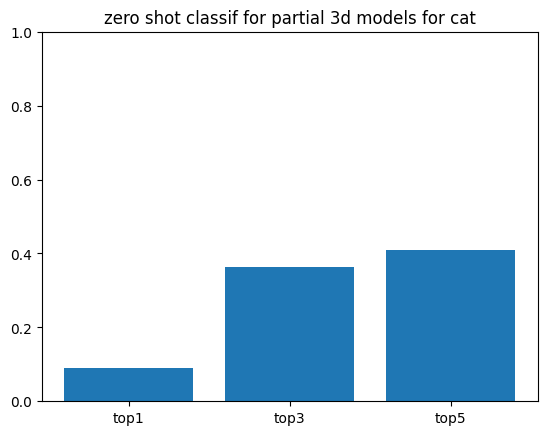

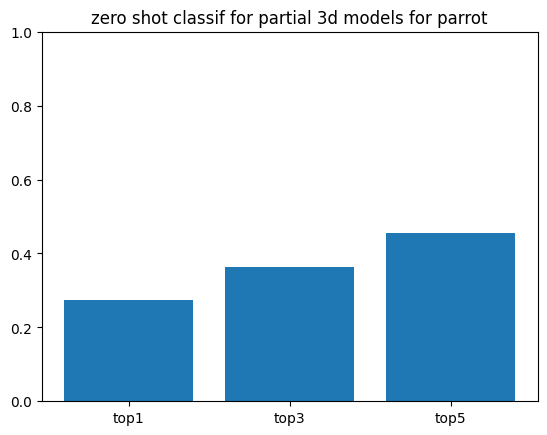

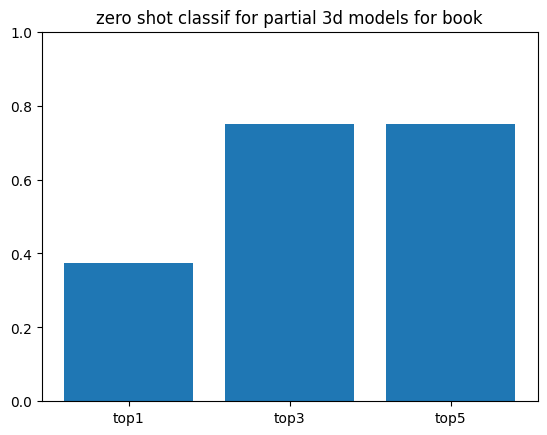

In [394]:
top1partial = "0.2222222222222222,0.0,0.5517241379310345,0.09090909090909091,0.25,0.045454545454545456,0.0,0.0,0.0,0.21739130434782608,0.3076923076923077,0.0,0.1111111111111111,0.0,0.4,0.4375,0.5714285714285714,0.0,0.0,0.0,0.14285714285714285,0.5,0.3333333333333333,0.8857142857142857,0.07692307692307693,0.0,0.07692307692307693,0.0,0.2692307692307692,0.1,0.0,0.45454545454545453,0.0,0.2857142857142857,0.1111111111111111,0.3333333333333333,0.0,0.42857142857142855,0.0,0.27586206896551724,0.0,0.14285714285714285,0.0,0.0,0.5384615384615384,0.0,0.29411764705882354,0.0,0.7916666666666666,0.0,0.07142857142857142,0.0,0.0,0.0,0.8695652173913043,0.14285714285714285,0.0,0.07692307692307693,0.0,0.7857142857142857,0.2857142857142857,0.0,0.0,0.0,0.9310344827586207,0.0,0.36,0.0,0.53125,0.6666666666666666,0.0,0.0,0.0,0.0,0.0,0.8947368421052632,0.0,0.4375,0.0,0.3333333333333333,0.21428571428571427,0.0,0.11764705882352941,0.5789473684210527,0.0,0.0,0.48,0.6363636363636364,0.0,0.0,0.0,0.0,0.0,0.18181818181818182,0.1111111111111111,0.0,0.125,0.29213483146067415,0.375,0.6,0.0,0.3125,0.5384615384615384,0.0,0.09523809523809523,0.07692307692307693,0.0,0.3888888888888889,0.0,0.5,0.0,0.0625,0.125,0.0,0.0,0.5555555555555556,0.2,0.0,0.0,0.6666666666666666,0.5384615384615384,0.6363636363636364,0.0,0.0,0.7272727272727273,0.6666666666666666,0.4,0.2911392405063291,0.391304347826087,0.0,0.09090909090909091,0.0,0.0,0.06666666666666667,0.0,0.09523809523809523,0.08333333333333333,0.48,0.6666666666666666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.1875,0.047619047619047616,0.2777777777777778,0.0,0.5,0.0,0.0,0.391304347826087,0.0,0.2413793103448276,0.1875,0.0,0.0,0.05263157894736842,0.0,0.14285714285714285,0.3333333333333333,0.08333333333333333,0.16666666666666666,0.42857142857142855,0.07142857142857142,0.45454545454545453,0.0,0.0,0.0,0.0,0.2222222222222222,0.35714285714285715,0.0,0.375,0.391304347826087,0.0,0.35714285714285715,0.0,0.0,0.1,0.0,0.1,0.0,0.14285714285714285,0.0,0.5714285714285714,0.2857142857142857,0.375,0.11764705882352941,0.5,0.0,0.09090909090909091,0.14285714285714285,0.125,0.3333333333333333,0.05555555555555555,0.1111111111111111,0.0,0.4444444444444444,0.875,0.0,0.14285714285714285,0.08333333333333333,0.2727272727272727,0.0,0.0,0.25,0.47368421052631576,0.3333333333333333,0.0,0.0,0.14285714285714285,0.625,0.0,0.0,0.3,0.11764705882352941,0.0,0.42857142857142855,0.43243243243243246,0.0,0.0,0.5,0.0,0.5714285714285714,0.0,0.2727272727272727,0.3333333333333333,0.0,0.4166666666666667,0.32,0.2857142857142857,0.43333333333333335,0.8571428571428571,0.6,0.16666666666666666,0.125,0.7586206896551724,0.7272727272727273,0.0,0.16666666666666666,0.2857142857142857,0.5217391304347826,0.13333333333333333,0.20689655172413793,0.18181818181818182,0.6428571428571429,0.0,0.0,0.05,0.16666666666666666,0.2631578947368421,0.5,0.8571428571428571,0.13333333333333333,0.0,0.125,0.4,0.0,0.0,0.23809523809523808,0.0,0.0,0.3,0.3,0.45,0.0,0.38461538461538464,0.1875,0.25,0.6428571428571429,0.2,0.16666666666666666,0.45454545454545453,0.0,0.0,0.0,0.0,0.0,0.0,0.5625,0.0,0.2,0.0625,0.2631578947368421,0.125,0.625,0.14285714285714285,0.42857142857142855,0.0,0.09090909090909091,0.125,0.0,0.6842105263157895,0.0,0.0,0.0,0.2,0.0,0.5882352941176471,0.45454545454545453,0.1,0.0,0.0,0.26666666666666666,0.125,0.13793103448275862,0.4166666666666667,0.2777777777777778,0.0,0.0,0.0,0.3333333333333333,0.0,0.043478260869565216,0.05405405405405406,0.25,0.0,0.0,0.16666666666666666,0.2,0.0,0.1111111111111111,0.0967741935483871,0.42857142857142855,0.0,0.4444444444444444,0.09523809523809523,0.0,0.0,0.0,0.25,0.6666666666666666,0.09090909090909091,0.0,0.5833333333333334,0.0,0.3333333333333333,0.0,0.5,0.5,0.0,0.0,0.05,0.4,0.0,0.1875,0.0,0.10526315789473684,0.7272727272727273,0.0,0.0,0.4444444444444444,0.7777777777777778,0.6818181818181818,0.0,0.8,0.0,0.0,0.1111111111111111,0.0,0.0,0.0,0.0,0.0625,0.0,0.25,0.2222222222222222,0.0,0.0,0.13333333333333333,0.2222222222222222,0.14285714285714285,0.3333333333333333,0.25,0.08333333333333333,0.6666666666666666,0.0,0.0,0.1,0.22727272727272727,0.5714285714285714,0.0,0.1111111111111111,0.0,0.034482758620689655,0.0,0.0,0.6,0.0,0.4,0.42857142857142855,0.2727272727272727,0.5666666666666667,0.0,0.2,0.29411764705882354,0.14285714285714285,0.0,0.0,0.6666666666666666,0.4722222222222222,0.0,0.45454545454545453,0.0,0.0,0.14285714285714285,0.0,0.5,0.0,0.0,0.2222222222222222,0.21428571428571427,0.0,0.07142857142857142,0.05263157894736842,0.1,0.047619047619047616,0.1111111111111111,0.11764705882352941,0.058823529411764705,0.6296296296296297,0.0,0.0,0.43478260869565216,0.14285714285714285,0.125,0.0,0.125,0.0,0.75,0.14285714285714285,0.2,0.0,0.6666666666666666,0.35714285714285715,0.0,0.0,0.36363636363636365,0.5454545454545454,0.16666666666666666,0.1111111111111111,0.0,0.5,0.0,0.0,0.5,0.15384615384615385,0.0,0.9333333333333333,0.0,0.058823529411764705,0.06666666666666667,0.16666666666666666,0.0,0.3125,0.0,0.0,0.0,0.0,0.07142857142857142,0.25,0.16666666666666666,0.0,0.0,0.0,0.5555555555555556,0.0,0.0,0.0,0.125,0.2727272727272727,0.07692307692307693,0.375,0.0,0.0,0.1111111111111111,0.2,0.25,0.0,0.2222222222222222,0.3076923076923077,0.0,0.0,0.0,0.0,0.2857142857142857,0.0,0.0,0.0,0.0,0.0,0.4375,0.0,0.0,0.0,0.0,0.2,0.0,0.5,0.0,0.0,0.0,0.14285714285714285,0.125,0.0,0.0,0.0,0.0,0.0,0.16666666666666666,0.1891891891891892,0.25,0.0,0.5,0.08333333333333333,0.0,0.0,0.6923076923076923,0.0,0.0,0.0,0.4,0.5384615384615384,0.75,0.0,0.0,0.0,0.6,0.36363636363636365,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.23529411764705882,0.5714285714285714,0.25,0.2,0.0,0.7142857142857143,0.2,0.5,0.2857142857142857,0.0,0.0,0.14285714285714285,0.2,0.0,0.2,0.2,0.0,0.2,0.0,0.0,0.05555555555555555,0.14285714285714285,0.0,0.25,0.3076923076923077,0.0,0.0,0.5,0.0,0.0,0.25,0.06666666666666667,0.14285714285714285,0.08333333333333333,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.3,0.0,0.0,0.16666666666666666,0.5,0.4,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.1111111111111111,0.0,0.0,0.0,0.5,0.25,0.0,0.0,0.0,0.0,0.07692307692307693,0.0,0.0,0.0,0.25,0.0,0.058823529411764705,0.6,0.0,0.0,0.0,0.14285714285714285,0.10526315789473684,0.0,0.16666666666666666,0.0,0.0,0.23076923076923078,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.3125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2857142857142857,0.0,0.8823529411764706,0.0,0.0,0.0,0.0,0.0,0.0,0.375,0.0,0.058823529411764705,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,0.2222222222222222,0.0,0.07142857142857142,0.35714285714285715,0.06666666666666667,0.0,0.0,0.3333333333333333,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.5333333333333333,0.0,0.0,0.16666666666666666,0.42105263157894735,0.0,0.0,0.3888888888888889,0.0,0.0,0.0,0.0,0.42857142857142855,0.6666666666666666,0.3333333333333333,0.0,0.0,0.0,0.3125,0.0,0.0,0.0,0.375,0.23076923076923078,0.125,0.0,0.4,0.14285714285714285,0.1,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.2692307692307692,0.0,0.0,0.0,0.4444444444444444,0.0,0.0,0.0,0.1111111111111111,0.0,0.0,0.0,0.0,0.0,0.3333333333333333,0.5555555555555556,0.0,0.0,0.15789473684210525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15384615384615385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2857142857142857,0.3333333333333333,0.0,0.16666666666666666,0.4,0.0,0.0,0.0,0.0,0.42857142857142855,0.0,0.125,0.3333333333333333,0.0,0.0,0.5,0.0,0.0,0.0,0.6666666666666666,0.0,0.0,0.0,0.0,0.5,0.07692307692307693,0.45454545454545453,0.045454545454545456,0.0,0.0,0.0,0.0,0.16666666666666666,0.0,0.0,0.25,0.3333333333333333,0.0,0.0,0.0,0.125,0.0,0.0,0.2222222222222222,0.0,0.0,0.4,0.0,0.09090909090909091,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.14285714285714285,0.25,0.0,0.0,0.0,0.0,0.75,0.0,0.05263157894736842,0.0,0.09090909090909091,0.0,1.0,0.5,0.6666666666666666,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.6666666666666666,0.42857142857142855,0.0,0.0,0.5,0.3,0.1111111111111111,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.3333333333333333,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.8333333333333334,0.375,0.0,0.2,0.0,0.16666666666666666,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.2,0.2222222222222222,0.0,0.0,0.0,0.6666666666666666,0.0,0.0,0.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.1111111111111111,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.0,0.6666666666666666,0.0,0.0,1.0,0.0,0.16666666666666666,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.2,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.16666666666666666,0.0,0.0,0.2,0.0,0.0,0.0,0.5,0.16666666666666666,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14285714285714285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3333333333333333,0.0,0.0,0.3333333333333333,0.18181818181818182,0.0,0.25,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3333333333333333,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"
top3partial = "0.37037037037037035,0.0,0.8620689655172413,0.09090909090909091,0.3333333333333333,0.22727272727272727,0.0,0.0,0.0,0.391304347826087,0.46153846153846156,0.0,0.4444444444444444,0.06666666666666667,1.0,0.4375,0.7857142857142857,0.0,0.0,0.0,0.2857142857142857,0.5666666666666667,0.3888888888888889,0.9428571428571428,0.46153846153846156,0.0,0.07692307692307693,0.08333333333333333,0.4230769230769231,0.4,0.0,0.6363636363636364,0.0,0.5714285714285714,0.2222222222222222,0.5,0.0,0.7142857142857143,0.0,0.3793103448275862,0.0,0.23809523809523808,0.0,0.0,0.6538461538461539,0.0,0.38235294117647056,0.2857142857142857,0.875,0.1111111111111111,0.14285714285714285,0.0,0.16666666666666666,0.17857142857142858,0.9130434782608695,0.2857142857142857,0.0,0.46153846153846156,0.3333333333333333,0.7857142857142857,0.75,0.23529411764705882,0.0,0.0,1.0,0.0,0.8,0.0,0.71875,0.8333333333333334,0.0,0.75,0.0,0.0,0.0,0.8947368421052632,0.0,0.53125,0.36363636363636365,0.3333333333333333,0.35714285714285715,0.0,0.17647058823529413,0.6842105263157895,0.125,0.1,0.64,0.9090909090909091,0.0,0.0,0.07142857142857142,0.0,0.0,0.36363636363636365,0.3333333333333333,0.0,0.25,0.5168539325842697,0.375,0.8,0.0,0.375,0.6923076923076923,0.4,0.38095238095238093,0.23076923076923078,0.0,0.6111111111111112,0.1111111111111111,0.8888888888888888,0.0,0.25,0.25,0.0,0.0,0.6666666666666666,0.4,0.25,0.125,0.7777777777777778,0.6153846153846154,0.7727272727272727,0.125,0.06666666666666667,0.8181818181818182,0.75,0.5142857142857142,0.43037974683544306,0.5217391304347826,0.16666666666666666,0.2727272727272727,0.0,0.0,0.26666666666666666,0.0,0.5714285714285714,0.5,0.8,0.7777777777777778,0.0,0.16666666666666666,0.0,0.08333333333333333,0.0,0.16666666666666666,0.0,0.25,0.1875,0.3333333333333333,0.3333333333333333,0.0,0.5,0.11764705882352941,0.5,0.5217391304347826,0.47058823529411764,0.41379310344827586,0.5,0.0,0.0,0.15789473684210525,0.0,0.2857142857142857,0.4166666666666667,0.16666666666666666,0.3333333333333333,0.6428571428571429,0.2857142857142857,0.6363636363636364,0.18181818181818182,0.0,0.2,0.0,0.4444444444444444,0.5714285714285714,0.0,0.375,0.6521739130434783,0.0,0.5,0.0,0.38461538461538464,0.1,0.07692307692307693,0.3,0.25,0.21428571428571427,0.0,0.7142857142857143,0.42857142857142855,0.75,0.29411764705882354,0.75,0.3333333333333333,0.18181818181818182,0.2857142857142857,0.25,0.5555555555555556,0.05555555555555555,0.3888888888888889,0.0,0.5185185185185185,0.9375,0.0,0.14285714285714285,0.25,0.36363636363636365,0.0,0.0,0.5,0.5789473684210527,0.3333333333333333,0.2857142857142857,0.18181818181818182,0.21428571428571427,0.75,0.08333333333333333,0.0,0.45,0.23529411764705882,0.0,0.5714285714285714,0.6756756756756757,0.0,0.0,0.5,0.09090909090909091,0.5714285714285714,0.0,0.7272727272727273,0.5555555555555556,0.058823529411764705,0.75,0.48,0.35714285714285715,0.5333333333333333,0.9642857142857143,0.6666666666666666,0.3333333333333333,0.125,0.8620689655172413,0.8181818181818182,0.0,0.16666666666666666,0.5714285714285714,0.5217391304347826,0.13333333333333333,0.3448275862068966,0.18181818181818182,0.6428571428571429,0.18181818181818182,0.6,0.25,0.3333333333333333,0.3684210526315789,0.5,1.0,0.4666666666666667,0.0,0.125,0.8,0.1,0.0,0.3333333333333333,0.08333333333333333,0.07142857142857142,0.5,0.4,0.55,0.0,0.46153846153846156,0.375,0.25,0.8571428571428571,0.2,0.3333333333333333,0.5,0.0,0.2,0.0,0.0,0.0,0.38461538461538464,0.875,0.5,0.2,0.125,0.47368421052631576,0.25,0.625,0.14285714285714285,0.7142857142857143,0.25,0.18181818181818182,0.25,0.1,0.9473684210526315,0.0,0.4,0.0,0.2,0.0,0.7058823529411765,0.6363636363636364,0.5,0.0,0.0,0.36666666666666664,0.25,0.2413793103448276,0.5,0.6666666666666666,0.0,0.0,0.0,0.47619047619047616,0.18181818181818182,0.21739130434782608,0.24324324324324326,0.3125,0.0,0.0,0.3333333333333333,0.5,0.0,0.2777777777777778,0.16129032258064516,0.42857142857142855,0.2222222222222222,0.6666666666666666,0.3333333333333333,0.0,0.0,0.0,0.625,0.6666666666666666,0.36363636363636365,0.15789473684210525,0.6666666666666666,0.0,0.3333333333333333,0.25,0.5,0.5714285714285714,0.3333333333333333,0.2,0.3,0.5,0.25,0.1875,0.0,0.2631578947368421,0.8181818181818182,0.0,0.0,0.5555555555555556,0.8888888888888888,0.7272727272727273,0.0,1.0,0.0,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.3333333333333333,0.0,0.0,0.6666666666666666,0.3888888888888889,0.5,0.5,0.4375,0.16666666666666666,0.6666666666666666,0.0,0.1,0.25,0.22727272727272727,0.7142857142857143,0.0,0.5555555555555556,0.0,0.27586206896551724,0.0,0.0,0.6,0.0,0.6,0.8571428571428571,0.36363636363636365,0.6333333333333333,0.07142857142857142,0.3,0.47058823529411764,0.2857142857142857,0.0,0.21428571428571427,0.8333333333333334,0.5555555555555556,0.16666666666666666,0.6060606060606061,0.0,0.0,0.21428571428571427,0.0,0.5,0.0,0.0,0.5555555555555556,0.5,0.0,0.14285714285714285,0.10526315789473684,0.1,0.3333333333333333,0.1111111111111111,0.17647058823529413,0.4117647058823529,0.7407407407407407,0.2,0.06666666666666667,0.6956521739130435,0.42857142857142855,0.125,0.0,0.375,0.75,0.75,0.14285714285714285,0.2,0.3333333333333333,0.7777777777777778,0.5714285714285714,0.0,0.1,0.9090909090909091,0.5454545454545454,0.16666666666666666,0.2222222222222222,0.14285714285714285,0.7,0.0,0.4444444444444444,0.5,0.46153846153846156,0.0,0.9333333333333333,0.0,0.23529411764705882,0.2,1.0,0.0,0.4375,0.0,0.0,0.0,0.3333333333333333,0.14285714285714285,0.25,0.5,0.0,0.0,0.0,0.7777777777777778,0.16666666666666666,0.0,0.0,0.125,0.4090909090909091,0.3076923076923077,0.75,0.2,0.0,0.1111111111111111,0.6,0.5,0.0,0.3333333333333333,0.7692307692307693,0.0,0.0,0.3333333333333333,0.0,0.42857142857142855,0.125,0.0,0.1111111111111111,0.0,0.0,0.5625,0.0,0.0,0.0,0.25,0.2,0.0,0.5714285714285714,0.0,0.0,0.0,0.14285714285714285,0.375,0.08333333333333333,0.0,0.0,0.0,0.4,0.5,0.5405405405405406,0.25,0.0,0.6666666666666666,0.16666666666666666,0.09090909090909091,0.0,0.6923076923076923,0.0,0.0,0.0,0.4666666666666667,0.5769230769230769,0.75,0.0,0.09090909090909091,0.0,0.7,0.7272727272727273,0.0,0.0,0.0,0.0,0.15,0.42857142857142855,0.0,0.0,0.47058823529411764,0.5714285714285714,0.5,0.3,0.0,0.7857142857142857,0.5,0.625,0.2857142857142857,0.0,0.0,0.2857142857142857,0.4,0.2,0.6,0.6,0.0,0.3,0.0,0.5714285714285714,0.05555555555555555,0.14285714285714285,0.5714285714285714,0.5,0.6153846153846154,0.0,0.0,1.0,0.0,0.25,0.25,0.06666666666666667,0.2857142857142857,0.25,0.1,0.14285714285714285,0.0,0.0,0.0,0.0,0.0,0.2,1.0,0.2857142857142857,0.0,0.0,0.4,0.0,0.2,0.3333333333333333,0.5,0.55,0.0,0.1,0.0,0.9166666666666666,0.0,0.0,0.0,0.0,0.0,0.3333333333333333,0.0,0.0,0.0,0.6,0.25,0.0,0.1111111111111111,0.0,0.0,0.07692307692307693,0.0,0.0,0.46153846153846156,0.75,0.2,0.11764705882352941,0.8,0.0,0.09090909090909091,0.0,0.35714285714285715,0.3157894736842105,0.0,0.25,0.8333333333333334,0.0,0.23076923076923078,0.14285714285714285,0.4166666666666667,0.1,0.5,0.125,0.0,0.0,0.6,0.0,0.0,0.3333333333333333,0.0,0.5,0.0,0.2222222222222222,0.0,0.0,0.0,0.0,0.2,0.3333333333333333,0.2,0.14285714285714285,0.42857142857142855,0.0,0.9411764705882353,0.0,0.1111111111111111,0.3333333333333333,0.3333333333333333,0.0,0.0,0.625,0.0,0.7647058823529411,0.5,0.0,0.0,0.0,0.0,0.2,0.0,0.1875,0.0,0.2222222222222222,0.0,0.07142857142857142,0.6428571428571429,0.26666666666666666,0.1111111111111111,0.0,0.3333333333333333,0.3333333333333333,0.14285714285714285,0.0,0.1,0.25,0.0,0.3333333333333333,0.2857142857142857,0.6,0.0,0.0,0.16666666666666666,0.631578947368421,0.0,0.0,0.6666666666666666,0.0,0.3333333333333333,0.0,0.0,0.7142857142857143,0.6666666666666666,0.3333333333333333,0.5,0.0,0.3333333333333333,0.8125,0.1,0.0,0.0,0.6875,0.38461538461538464,0.25,0.5,0.4,0.14285714285714285,0.15,0.35294117647058826,0.25,1.0,0.44,0.0,0.38461538461538464,0.0,0.0,0.3076923076923077,0.0,0.0,0.0,0.4444444444444444,0.2,0.0,0.25,0.1111111111111111,0.0,0.0,0.4,0.0,0.0,0.3333333333333333,0.6666666666666666,0.0,0.0,0.3157894736842105,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.4,0.0,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.16666666666666666,0.0,0.0,0.0,0.0,0.42857142857142855,0.23076923076923078,0.25,0.25,0.0,0.2,0.0,0.0,0.0,0.42857142857142855,0.3333333333333333,0.1,0.16666666666666666,0.6,0.0,0.0,0.5,0.3333333333333333,0.5714285714285714,0.0,0.25,0.3333333333333333,0.0,0.0,0.5,0.42857142857142855,0.0,0.0,0.6666666666666666,0.0,0.4,0.0,0.2222222222222222,0.5,0.15384615384615385,0.8181818181818182,0.2727272727272727,0.0,0.0,0.0,0.125,0.16666666666666666,0.0,0.0,0.25,0.5,0.3333333333333333,0.0,0.0,0.375,0.2222222222222222,0.0,0.4444444444444444,0.0,0.25,0.5,0.0,0.18181818181818182,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.3333333333333333,0.0,0.14285714285714285,0.25,0.16666666666666666,0.0,0.14285714285714285,0.0,0.75,0.0,0.47368421052631576,0.5,0.45454545454545453,0.0,1.0,1.0,0.8333333333333334,0.3333333333333333,0.0,0.375,0.0,0.0,0.0,0.0,0.5,0.375,0.0,0.0,0.0,0.0,0.0,0.8333333333333334,0.42857142857142855,0.0,0.0,0.625,0.6,0.1111111111111111,0.0,0.0,0.4,0.16666666666666666,0.0,0.0,0.0,0.25,0.0,0.75,0.16666666666666666,0.4,0.3333333333333333,0.125,0.0,0.0,1.0,1.0,0.0,0.0,0.3333333333333333,0.25,0.0,0.0,0.0,0.0,0.8333333333333334,0.375,0.0,0.4,0.0,0.6666666666666666,0.0,0.0,0.4,0.0,0.25,0.3333333333333333,0.0,0.2,0.5555555555555556,0.0,0.0,0.25,0.6666666666666666,0.0,0.14285714285714285,0.5,0.09090909090909091,0.25,0.0,0.0,0.3333333333333333,0.0,0.2,0.0,0.0,0.0,0.0,0.25,0.1,0.0,0.0,0.0,0.0,0.6666666666666666,0.0,0.0,0.0,0.0,0.0,0.2222222222222222,0.3333333333333333,0.3333333333333333,0.0,0.0,0.2857142857142857,0.0,0.0,1.0,0.0,0.3333333333333333,1.0,0.0,0.3333333333333333,0.0,0.0,0.0,0.3333333333333333,0.0,0.0,0.8333333333333334,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.2857142857142857,0.8,0.0,0.2,0.0,0.5,0.0,0.0,0.0,0.0,0.3333333333333333,0.5,0.0,0.0,0.3333333333333333,0.0,0.0,0.3333333333333333,0.0,0.0,0.4,0.0,0.3333333333333333,0.0,0.0,0.6,0.0,0.5,0.0,0.625,0.16666666666666666,0.5,0.0,1.0,0.0,0.0,0.0,0.09090909090909091,0.0,0.0,0.14285714285714285,0.0,0.0,0.0,0.3333333333333333,0.0,0.0,0.3333333333333333,0.0,0.25,0.25,0.0,0.0,0.0,0.25,0.0,0.3333333333333333,0.0,0.0,0.0,0.2,0.0,0.25,0.0,0.6666666666666666,0.0,0.0,0.6666666666666666,0.45454545454545453,0.0,0.25,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6666666666666666,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.4,1.0,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.3333333333333333,0.0,1.0,0.6666666666666666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3333333333333333,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.5,0.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0"
top5partial = "0.4074074074074074,0.0,0.896551724137931,0.18181818181818182,0.5,0.4090909090909091,0.0,0.0,0.0,0.5217391304347826,0.6153846153846154,0.0,0.7777777777777778,0.13333333333333333,1.0,0.5,0.8571428571428571,0.0,0.0,0.0,0.42857142857142855,0.6,0.5555555555555556,0.9428571428571428,0.6923076923076923,0.0,0.07692307692307693,0.08333333333333333,0.4230769230769231,0.5,0.2,0.7727272727272727,0.0,0.6428571428571429,0.2222222222222222,0.5,0.0,0.7857142857142857,0.07692307692307693,0.4482758620689655,0.0,0.42857142857142855,0.13333333333333333,0.0,0.6923076923076923,0.09090909090909091,0.5,0.2857142857142857,0.9583333333333334,0.2222222222222222,0.14285714285714285,0.14285714285714285,0.16666666666666666,0.35714285714285715,0.9130434782608695,0.42857142857142855,0.25,0.6153846153846154,0.4166666666666667,0.7857142857142857,0.7857142857142857,0.5294117647058824,0.0,0.0,1.0,0.0,0.84,0.0,0.78125,0.8333333333333334,0.0,0.75,0.0,0.0,0.0,0.8947368421052632,0.125,0.625,0.45454545454545453,0.6666666666666666,0.35714285714285715,0.1111111111111111,0.17647058823529413,0.6842105263157895,0.125,0.2,0.64,1.0,0.0,0.0,0.35714285714285715,0.0,0.0,0.5454545454545454,0.3333333333333333,0.0,0.25,0.6179775280898876,0.375,1.0,0.0,0.375,0.6923076923076923,0.6,0.42857142857142855,0.3076923076923077,0.0,0.6666666666666666,0.16666666666666666,0.9444444444444444,0.0,0.375,0.4375,0.0,0.0,0.7777777777777778,0.4,0.25,0.375,0.8333333333333334,0.7692307692307693,0.8181818181818182,0.125,0.06666666666666667,0.8636363636363636,0.75,0.6571428571428571,0.4936708860759494,0.5652173913043478,0.16666666666666666,0.36363636363636365,0.0,0.09090909090909091,0.26666666666666666,0.0,0.6190476190476191,0.6666666666666666,0.88,0.8518518518518519,0.0,0.16666666666666666,0.0,0.16666666666666666,0.0,0.16666666666666666,0.0,0.25,0.1875,0.38095238095238093,0.3333333333333333,0.0,0.5,0.29411764705882354,0.5,0.6086956521739131,0.5294117647058824,0.4827586206896552,0.5,0.3333333333333333,0.16666666666666666,0.21052631578947367,0.0,0.2857142857142857,0.4166666666666667,0.16666666666666666,0.3333333333333333,0.8571428571428571,0.5,0.6363636363636364,0.18181818181818182,0.0,0.2,0.0,0.4444444444444444,0.5714285714285714,0.0,0.5,0.7391304347826086,0.0,0.5714285714285714,0.0,0.38461538461538464,0.1,0.07692307692307693,0.4,0.5,0.25,0.0,0.7142857142857143,0.42857142857142855,0.75,0.4117647058823529,0.8333333333333334,0.3333333333333333,0.2727272727272727,0.2857142857142857,0.375,0.6666666666666666,0.05555555555555555,0.6666666666666666,0.0,0.6666666666666666,0.9375,0.0,0.21428571428571427,0.3333333333333333,0.45454545454545453,0.0,0.1111111111111111,0.5,0.5789473684210527,0.3333333333333333,0.8571428571428571,0.18181818181818182,0.35714285714285715,0.75,0.16666666666666666,0.16666666666666666,0.55,0.35294117647058826,0.0,0.6428571428571429,0.7297297297297297,0.16666666666666666,0.0,0.5454545454545454,0.09090909090909091,0.7142857142857143,0.0,0.8181818181818182,0.5555555555555556,0.058823529411764705,0.8333333333333334,0.48,0.42857142857142855,0.5666666666666667,1.0,0.7333333333333333,0.5,0.125,0.9655172413793104,0.8181818181818182,0.0,0.16666666666666666,0.5714285714285714,0.5217391304347826,0.2,0.3793103448275862,0.2727272727272727,0.6428571428571429,0.36363636363636365,0.8,0.3,0.4444444444444444,0.42105263157894735,0.5,1.0,0.5333333333333333,0.0,0.25,1.0,0.2,0.0,0.42857142857142855,0.16666666666666666,0.14285714285714285,0.6,0.5,0.65,0.0,0.5384615384615384,0.5,0.25,0.9285714285714286,0.25,0.3333333333333333,0.5454545454545454,0.0,0.5,0.0,0.3333333333333333,0.16666666666666666,0.6153846153846154,1.0,0.5,0.4,0.1875,0.47368421052631576,0.25,0.625,0.14285714285714285,0.8571428571428571,0.5,0.2727272727272727,0.375,0.5,0.9473684210526315,0.0,0.6,0.0,0.2,0.0,0.7058823529411765,0.8181818181818182,0.7,0.0,0.0,0.4,0.25,0.2413793103448276,0.6666666666666666,0.6666666666666666,0.0,0.0,0.0,0.6190476190476191,0.45454545454545453,0.34782608695652173,0.32432432432432434,0.375,0.0,0.0,0.3333333333333333,0.6,0.0,0.4444444444444444,0.1935483870967742,0.5714285714285714,0.2222222222222222,0.6666666666666666,0.38095238095238093,0.0,0.2222222222222222,0.0,0.75,0.6666666666666666,0.4090909090909091,0.21052631578947367,0.75,0.0,0.6666666666666666,0.25,0.5,0.5714285714285714,0.3333333333333333,0.2,0.5,0.55,0.5,0.1875,0.1,0.2631578947368421,0.9090909090909091,0.0,0.0,0.6666666666666666,0.8888888888888888,0.7272727272727273,0.5,1.0,0.1111111111111111,0.1111111111111111,0.3333333333333333,0.0,0.0,0.125,0.2,0.25,0.0,0.75,0.3333333333333333,0.0,0.0,0.8,0.3888888888888889,0.5714285714285714,0.6666666666666666,0.625,0.25,0.6666666666666666,0.0,0.1,0.3,0.22727272727272727,0.7142857142857143,0.0,0.5555555555555556,0.0,0.3103448275862069,0.0,0.0,0.6,0.3333333333333333,0.6,0.8571428571428571,0.36363636363636365,0.6666666666666666,0.07142857142857142,0.43333333333333335,0.7058823529411765,0.2857142857142857,0.0,0.35714285714285715,0.8333333333333334,0.6111111111111112,0.16666666666666666,0.696969696969697,0.0,0.0625,0.2857142857142857,0.0,0.5,0.02857142857142857,0.0,0.6666666666666666,0.6428571428571429,0.0,0.2857142857142857,0.10526315789473684,0.2,0.38095238095238093,0.1111111111111111,0.17647058823529413,0.4117647058823529,0.7777777777777778,0.4,0.2,0.7391304347826086,0.42857142857142855,0.125,0.5,0.375,0.75,0.75,0.14285714285714285,0.2,0.5555555555555556,0.7777777777777778,0.5714285714285714,0.0,0.1,0.9090909090909091,0.5454545454545454,0.3333333333333333,0.2222222222222222,0.2857142857142857,0.8,0.0,0.5555555555555556,0.5,0.5384615384615384,0.2222222222222222,0.9333333333333333,0.0,0.35294117647058826,0.2,1.0,0.0,0.5625,0.0,0.0,0.0,0.3333333333333333,0.21428571428571427,0.25,0.75,0.0,0.2,0.0,0.8888888888888888,0.16666666666666666,0.0,0.0,0.125,0.4090909090909091,0.38461538461538464,0.75,0.2,0.0,0.1111111111111111,0.8,0.625,0.0,0.3333333333333333,0.8461538461538461,0.3333333333333333,0.0,0.3333333333333333,0.0,0.7142857142857143,0.125,0.0,0.2222222222222222,0.0,0.0,0.6875,0.0,0.08333333333333333,0.0,0.5,0.2,0.0,0.6428571428571429,0.0,0.0,0.0,0.14285714285714285,0.375,0.08333333333333333,0.0,0.0,0.0,0.4,0.5,0.5405405405405406,0.25,0.0,0.6666666666666666,0.25,0.36363636363636365,0.25,0.7692307692307693,0.0,0.0,0.0,0.4666666666666667,0.6153846153846154,0.7916666666666666,0.25,0.09090909090909091,0.0,0.8,0.8181818181818182,0.0,0.0,0.0,0.0,0.3,0.42857142857142855,0.09090909090909091,0.0,0.5294117647058824,0.7142857142857143,0.5625,0.3,0.0,0.8571428571428571,0.6,0.625,0.42857142857142855,0.14285714285714285,0.0,0.7142857142857143,0.4,0.2,0.6,0.7333333333333333,0.0,0.4,0.0,0.5714285714285714,0.16666666666666666,0.14285714285714285,0.8571428571428571,0.6666666666666666,0.6153846153846154,0.08333333333333333,0.0,1.0,0.0,0.25,0.25,0.06666666666666667,0.42857142857142855,0.25,0.1,0.2857142857142857,0.0,0.1111111111111111,0.0,0.0,0.0,0.2,1.0,0.2857142857142857,0.0,0.07692307692307693,0.4,0.2222222222222222,0.2,0.5,0.5,0.6,0.0,0.1,0.0,0.9166666666666666,0.0,0.0,0.0,0.0,0.0,0.4444444444444444,0.0,0.0,0.0,0.8,0.5,0.0,0.2222222222222222,0.0,0.3333333333333333,0.07692307692307693,0.25,0.14285714285714285,0.6923076923076923,0.875,0.2,0.11764705882352941,0.8,0.0,0.2727272727272727,0.0,0.5,0.3157894736842105,0.0,0.3333333333333333,1.0,0.0,0.23076923076923078,0.2857142857142857,0.4166666666666667,0.2,0.5,0.125,0.0,0.0,0.7,0.0,0.0,0.3333333333333333,0.0,0.5,0.0,0.2222222222222222,0.0,0.0,0.0,0.0,0.2,0.6666666666666666,0.2,0.14285714285714285,0.8571428571428571,0.0,0.9705882352941176,0.0,0.1111111111111111,0.3333333333333333,0.3333333333333333,0.0,0.0,0.875,0.0,0.7647058823529411,0.5,0.5,0.0,0.0,0.5,0.4,0.14285714285714285,0.1875,0.0,0.5555555555555556,0.14285714285714285,0.14285714285714285,0.7142857142857143,0.4666666666666667,0.1111111111111111,0.0,0.3333333333333333,0.3333333333333333,0.42857142857142855,0.0,0.1,0.25,0.0,0.3333333333333333,0.2857142857142857,0.6,0.0,0.0,0.16666666666666666,0.631578947368421,0.0,0.0,0.7222222222222222,0.0,0.3333333333333333,0.16666666666666666,0.0,0.8571428571428571,1.0,0.3333333333333333,0.5,0.0,0.5,0.875,0.3,0.14285714285714285,0.0,0.6875,0.5384615384615384,0.25,0.5,0.5,0.2857142857142857,0.15,0.4117647058823529,0.25,1.0,0.44,0.5,0.38461538461538464,0.0,0.0,0.34615384615384615,0.0,0.0,0.0,0.5555555555555556,0.2,0.25,0.25,0.1111111111111111,0.0,0.0,0.4,0.125,0.0,0.3333333333333333,0.7777777777777778,0.0,0.2,0.5789473684210527,0.0,0.0,0.0,0.5,0.0,0.0,0.3333333333333333,0.7,0.0,0.0,0.6666666666666666,0.0,0.0,0.0,0.3333333333333333,0.3333333333333333,0.07692307692307693,0.16666666666666666,0.0,0.0,0.42857142857142855,0.3076923076923077,0.25,0.25,0.0,0.4,0.0,0.0,0.0,0.42857142857142855,0.3333333333333333,0.2,0.16666666666666666,0.6,0.0,0.0,0.75,0.3333333333333333,0.7142857142857143,0.0,0.25,0.3333333333333333,0.0,0.0,0.5,0.7142857142857143,0.0,0.5,0.6666666666666666,0.0,0.4,0.16666666666666666,0.4444444444444444,0.5,0.38461538461538464,0.9090909090909091,0.36363636363636365,0.2857142857142857,0.0,0.0,0.125,0.5,0.0,0.0,0.375,0.6666666666666666,0.3333333333333333,0.0,0.0,0.375,0.3333333333333333,0.0,0.6666666666666666,0.0,0.75,0.8,0.0,0.18181818181818182,0.0,0.125,0.0,0.75,0.0,0.0,0.25,0.0,0.5,0.07692307692307693,0.14285714285714285,0.25,0.16666666666666666,0.2,0.2857142857142857,0.0,0.75,0.0,0.47368421052631576,0.5,0.7272727272727273,0.0,1.0,1.0,0.8333333333333334,0.3333333333333333,0.0,0.5,0.2,0.2,0.0,0.0,1.0,0.625,0.0,0.0,0.0,1.0,0.0,0.8333333333333334,0.7142857142857143,0.16666666666666666,0.0,0.625,0.8,0.3333333333333333,0.0,1.0,0.6,0.16666666666666666,0.3333333333333333,0.2,0.0,0.25,0.0,0.75,0.3333333333333333,0.4,0.3333333333333333,0.25,0.0,0.0,1.0,1.0,0.0,0.0,0.3333333333333333,0.5,0.0,0.0,0.0,0.0,0.8333333333333334,0.375,0.0,0.6,0.0,0.75,0.0,0.0,0.4,0.0,0.25,0.3333333333333333,1.0,0.4,0.6666666666666666,0.0,0.16666666666666666,0.25,0.7777777777777778,0.0,0.14285714285714285,0.5,0.18181818181818182,0.25,0.25,0.0,0.3333333333333333,0.0,0.2,0.4,0.0,0.0,0.0,0.25,0.2,0.0,0.0,0.6666666666666666,0.5,0.6666666666666666,0.25,0.1,0.0,0.0,0.0,0.2222222222222222,0.6666666666666666,0.3333333333333333,0.0,0.0,0.2857142857142857,0.0,0.0,1.0,0.0,0.3333333333333333,1.0,0.0,0.3333333333333333,0.0,0.3333333333333333,0.0,0.3333333333333333,0.25,0.0,0.8333333333333334,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.0,0.0,0.0,0.0,0.2857142857142857,0.8,0.0,0.6,0.0,1.0,0.0,0.0,0.0,0.0,0.3333333333333333,0.5,0.0,0.0,0.3333333333333333,0.0,0.0,0.3333333333333333,0.0,0.0,0.8,0.0,0.3333333333333333,0.0,0.0,0.6,0.09090909090909091,0.5,0.0,0.75,0.16666666666666666,0.5,0.5,1.0,0.0,0.0,0.0,0.09090909090909091,0.0,0.0,0.14285714285714285,0.0,0.0,0.0,0.6666666666666666,0.0,0.0,0.3333333333333333,0.0,0.25,0.25,1.0,0.5,0.0,0.25,0.5,0.3333333333333333,0.0,0.0,0.0,0.4,0.0,0.5,0.0,0.6666666666666666,0.5,0.3333333333333333,1.0,0.6363636363636364,0.0,0.25,0.2,0.0,0.0,0.25,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6666666666666666,0.0,0.25,0.0,0.0,0.0,0.0,1.0,0.4,1.0,0.5,0.5,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.3333333333333333,0.0,1.0,0.6666666666666666,1.0,0.0,0.5,0.0,0.2,0.0,0.0,0.0,0.0,0.3333333333333333,0.0,0.0,0.0,0.0,0.0,0.3333333333333333,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0"
topspartial = [top1partial, top3partial, top5partial]
topspartial = split_and_numpy(topspartial)
plot_results(topspartial, tops_names, "zero shot classif for partial 3d models")

# Utils

In [17]:
!git pull -X theirs

remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 21 (delta 5), reused 21 (delta 5), pack-reused 0
Unpacking objects: 100% (21/21), 467.61 KiB | 3.65 MiB/s, done.
From https://github.com/Ugo-Insalaco/Uni3D
   7d9c86f..5bea8c6  main       -> origin/main
Updating 7d9c86f..5bea8c6
Fast-forward
 assets/655edd88cfa74d2cafc13c7aa387d137.npy | Bin 0 -> 286820 bytes
 assets/chat_gris.jpg                        | Bin 0 -> 35860 bytes
 assets/tigre.png                            | Bin 0 -> 129605 bytes
 data/image_embeddings_grey_cat.npy          | Bin 0 -> 4224 bytes
 data/image_embeddings_tigre.npy             | Bin 0 -> 4224 bytes
 data/text_embeddings_cat_blue_belly.npy     | Bin 0 -> 4224 bytes
 data/text_embeddings_green_eyes.npy         | Bin 0 -> 4224 bytes
 data/text_embeddings_purple_tail.npy        | Bin 0 -> 4224 bytes
 results/partial points/out.log              |  51 ++++++++++++++++++